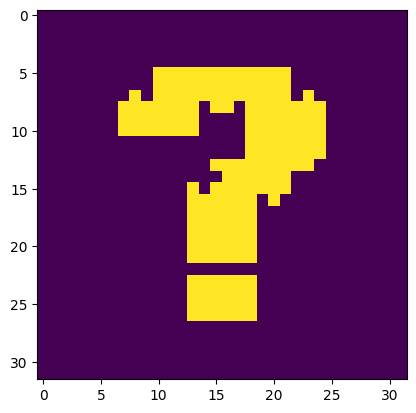

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

'''
First load in the substrate and visualise it
'''

substrate = np.load('data/toy_examples/question_mark_substrate.npy')

plt.imshow(substrate)

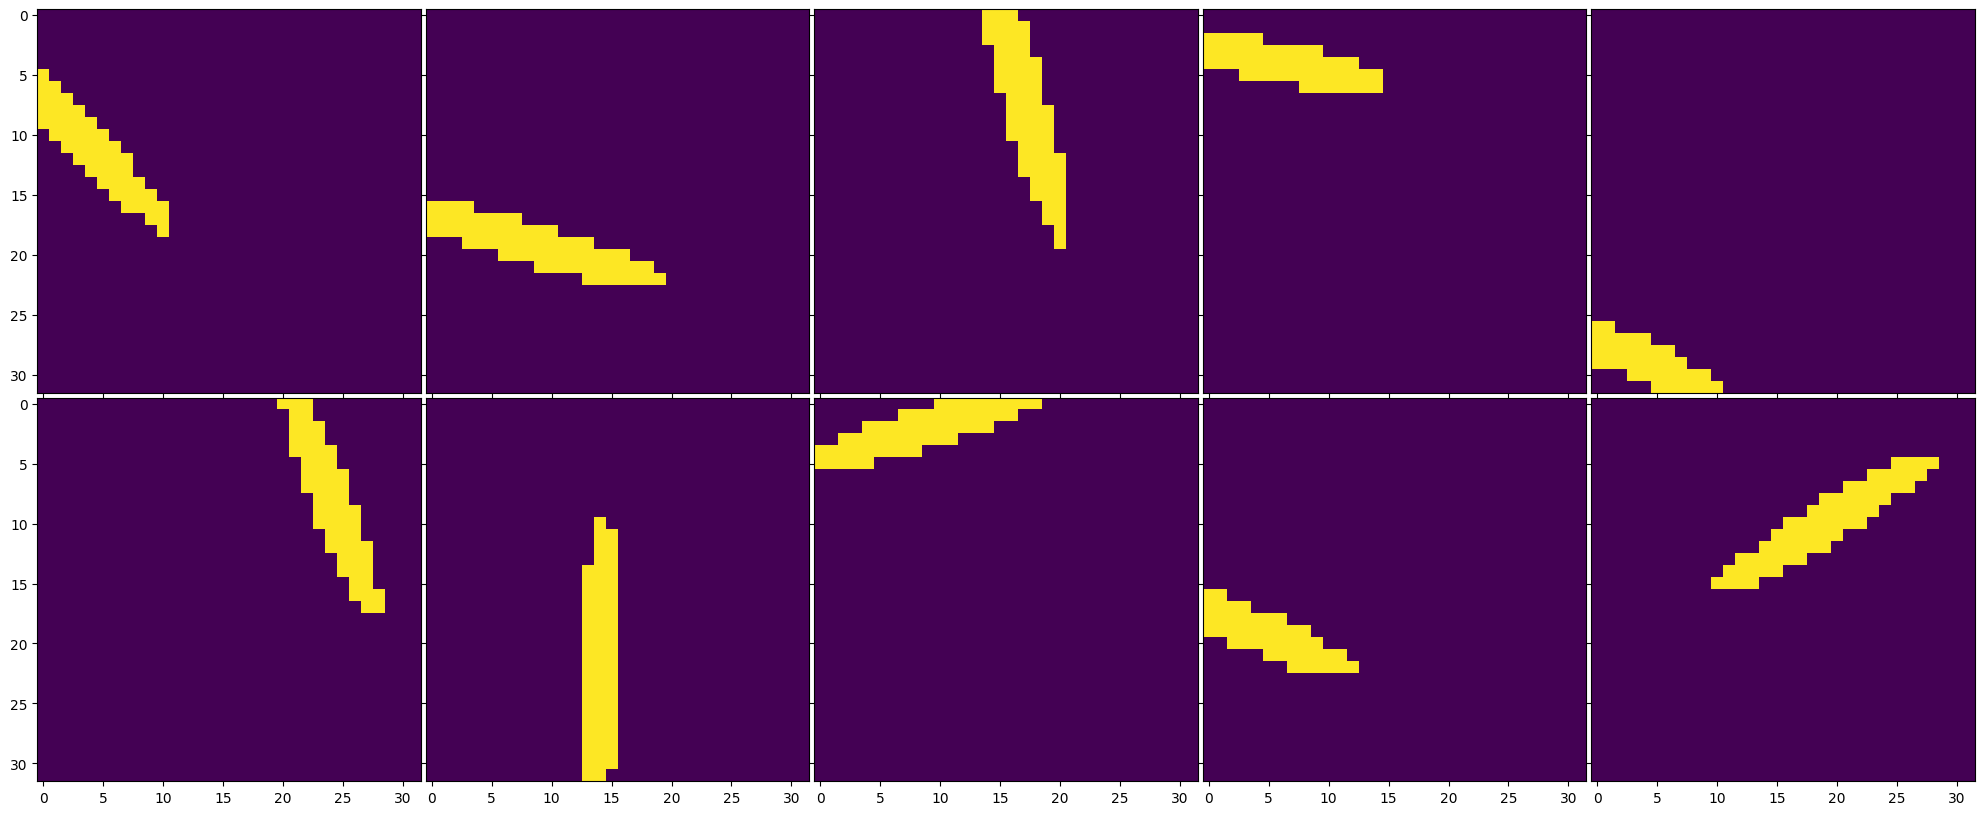

In [2]:
from mpl_toolkits.axes_grid1 import ImageGrid

'''
Load in 1000 32x32 lesions, that are basically just ellipsoids
'''

lesions = np.load('data/toy_examples/1000_lesions.npy')

# Let's visualise a few
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(2, 5),
                 axes_pad=0.05,
                 share_all=True
                 )

for i in range(10):
    grid[i].imshow(lesions[i])

(array([606.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 394.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

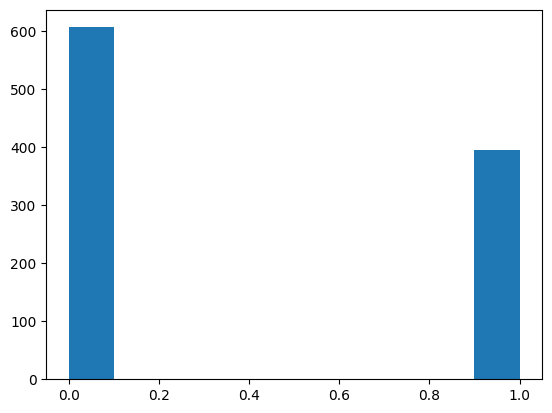

In [3]:
# LET'S SIMULATE SOME BINARY SCORES

# Threshold after which there is deficit
BINARY_THRESHOLD = 0.05

deficit_scores = [0 for i in range(len(lesions))]
positive_indices = []
for i in range(len(lesions)):
    overlap = lesions[i] * substrate
    counts = np.count_nonzero(overlap)
    voxels_gt = np.sum(substrate)
    ratio_lesion = counts / voxels_gt

    if ratio_lesion > BINARY_THRESHOLD:
        deficit_scores[i] = 1 
    else:
        deficit_scores[i] = 0
                
deficit_scores = np.array(deficit_scores)
plt.hist(deficit_scores)

In [4]:
from sklearn.model_selection import train_test_split

# WE NEED TO ADD ONE EXTRA CHANNEL AS DL MODELS EXPECT A COLOUR CHANNEL
lesions = np.expand_dims(lesions, axis=1)

# FIRST SPLIT INTO 90/10
train_data, vc_data, train_labels, vc_labels = train_test_split(lesions,
                                                                deficit_scores,
                                                                test_size=0.1)

# THEN SPLIT THE REMAINING 10% INTO VALIDATION AND CALIBRATION - 50/50
val_data, cal_data, val_labels, cal_labels = train_test_split(vc_data,
                                                              vc_labels,
                                                              test_size=0.5)

train_data.shape, val_data.shape, cal_data.shape

((900, 1, 32, 32), (50, 1, 32, 32), (50, 1, 32, 32))

In [5]:
from torch.utils.data import Dataset, DataLoader
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# class DeficitDataset(Dataset):

#     def __init__(self, data, labels):
#         self.data = data
#         self.labels = labels

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, index):
#         img = self.data[index]
#         return img, np.expand_dims(self.labels[index], axis=0)
    
    
class DeficitDataset(Dataset):
    """
    Dataset that holds tensors already on GPU.
    Works perfectly with DataLoader!
    """
    def __init__(self, data, labels, device):
        # Convert to tensors and move to GPU
        if isinstance(data, np.ndarray):
            self.data = torch.tensor(data, dtype=torch.float32, device=device)
        else:
            self.data = data.to(device)
            
        print(self.data.shape)
            
        if isinstance(labels, np.ndarray):
            self.labels = torch.tensor(labels, dtype=torch.float32, device=device)
        else:
            self.labels = labels.to(device)
        
        if self.labels.dim() == 1:
            self.labels = self.labels.unsqueeze(1)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        """
        DataLoader will call this method.
        Since data is already on GPU, this just returns GPU tensors!
        """
        return self.data[index], self.labels[index]

batch_size = 64

# CREATE DATA LOADERS
# TRAINING
dataset = DeficitDataset(data=train_data, labels=train_labels, device=device)
train_loader = DataLoader(dataset, batch_size=batch_size, drop_last=False,
                                            shuffle=True, num_workers=0, pin_memory=False)

# VALIDATION
val_dataset = DeficitDataset(data=val_data, labels=val_labels, device=device)
val_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=False,
                                            shuffle=True, num_workers=0, pin_memory=False)

# CALIBRATION
# cal_dataset = DeficitDataset(data=cal_data, labels=cal_labels)
# cal_loader = DataLoader(cal_dataset, batch_size=batch_size, drop_last=False,
#                                             shuffle=True, num_workers=10, pin_memory=True)


Using device: cuda:0
torch.Size([900, 1, 32, 32])
torch.Size([50, 1, 32, 32])


In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np


class SpatialSubstrate(nn.Module):
    def __init__(self, substrate_shape, latent_dim=32, base_size=4, kl_weight=1e-2):
        """
        Args:
            substrate_shape: tuple (C, H, W) - shape of substrate to generate
            latent_dim: dimensionality of latent code
            base_size: starting spatial size for decoder (will upsample to H, W)
            kl_weight: weight for KL divergence term
        """
        super().__init__()
        self.substrate_shape = substrate_shape
        self.latent_dim = latent_dim
        self.base_size = base_size
        self.kl_weight = kl_weight
        
        C, H, W = substrate_shape
        self.C, self.H, self.W = C, H, W
        
        # Variational parameters for latent code
        self.latent_mu = nn.Parameter(torch.randn(latent_dim) * 0.01)
        self.latent_log_sigma = nn.Parameter(torch.zeros(latent_dim) - 1.0)
        
        # Calculate number of upsampling layers needed
        n_upsample = int(np.log2(H / base_size))
        
        # Decoder: latent -> spatial substrate
        base_channels = 128
        self.fc = nn.Linear(latent_dim, base_channels * base_size * base_size)
        
        # Build upsampling layers
        layers = []
        in_channels = base_channels
        for i in range(n_upsample):
            out_channels = base_channels // (2 ** (i + 1))
            out_channels = max(out_channels, 16)
            
            layers.extend([
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, 
                                 stride=2, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2, inplace=True)
            ])
            in_channels = out_channels
        
        layers.append(
            nn.Conv2d(in_channels, C, kernel_size=3, padding=1)
        )
        
        self.decoder = nn.Sequential(*layers)
        
    def reparameterize(self, mu, log_sigma):
        """Reparameterization trick for sampling"""
        sigma = torch.exp(log_sigma)
        eps = torch.randn_like(sigma)
        return mu + sigma * eps
    
    def decode(self, z):
        """Decode latent code to substrate"""
        h = self.fc(z)
        h = h.view(1, -1, self.base_size, self.base_size)
        substrate = self.decoder(h)
        
        # Ensure correct spatial size
        if substrate.shape[-2:] != (self.H, self.W):
            substrate = F.interpolate(substrate, size=(self.H, self.W), 
                                     mode='bilinear', align_corners=False)
        
        return substrate.squeeze(0)
    
    def kl_divergence(self):
        """KL divergence between posterior q(z) and prior p(z) = N(0, I)"""
        mu = self.latent_mu
        log_sigma = self.latent_log_sigma
        sigma = torch.exp(log_sigma)
        
        kl = 0.5 * torch.sum(mu**2 + sigma**2 - 2*log_sigma - 1)
        return kl
    
    def forward(self, x, y, **_):
        """
        Forward pass matching your existing signature.
        
        Args:
            x: input tensor [B, C, H, W]
            y: target tensor [B] or [B, 1]
            
        Returns:
            dict with 'loss' and 'substrate_logits'
        """
        B = x.shape[0]
        
        # Sample latent code
        z = self.reparameterize(self.latent_mu, self.latent_log_sigma)
        
        # Decode to substrate
        substrate_logits = self.decode(z)  # [C, H, W]
        
        # Expand for batch
        substrate_logits = substrate_logits.unsqueeze(0).expand(B, -1, -1, -1)  # [B, C, H, W]
        
        # Your existing overlap computation
        overlap = x * substrate_logits
        logits_global = torch.mean(overlap, dim=(-3, -2, -1)).view(-1, 1)
        
        # BCE loss
        loss = F.binary_cross_entropy_with_logits(logits_global, y.float().view(-1, 1))
        
        # KL regularization
        kl = self.kl_divergence() / B  # normalize by batch size
        loss = loss + self.kl_weight * kl
        
        return {
            "loss": loss,
            "substrate_logits": substrate_logits,
        }


def sample_substrates(substrate_model, n_samples=100):
    """
    Sample multiple substrates for visualization/analysis.
    
    Args:
        substrate_model: SpatialSubstrate model
        n_samples: number of substrates to sample
    
    Returns:
        torch.Tensor of shape [n_samples, C, H, W]
    """
    with torch.no_grad():
        samples = []
        for _ in range(n_samples):
            z = substrate_model.reparameterize(substrate_model.latent_mu, 
                                              substrate_model.latent_log_sigma)
            substrate = substrate_model.decode(z)
            samples.append(substrate)
        return torch.stack(samples)

In [45]:
import torch
import numpy as np
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

substrate_shape = (1, 32, 32)
model = SpatialSubstrate(substrate_shape, latent_dim=32, kl_weight=1e-2).to(device)

    # Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    
scheduler = CosineAnnealingLR(optimizer, T_max=3000, eta_min=1e-6)

Epoch 0: train=0.6946, val=0.6928
torch.Size([32, 1, 32, 32])


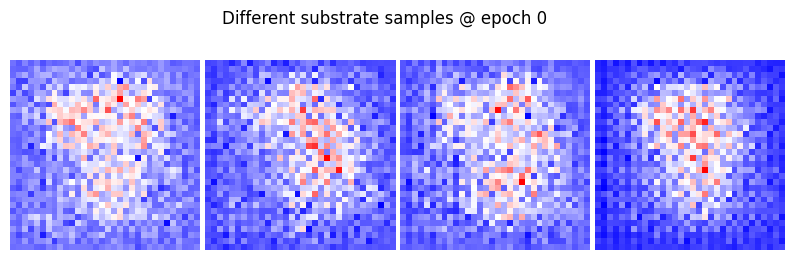

Epoch 1: train=0.6925, val=0.6861
Epoch 2: train=0.6884, val=0.6839
Epoch 3: train=0.6859, val=0.6730
Epoch 4: train=0.6819, val=0.6726
Epoch 5: train=0.6776, val=0.6753
Epoch 6: train=0.6746, val=0.6667
Epoch 7: train=0.6711, val=0.6662
Epoch 8: train=0.6667, val=0.6624
Epoch 9: train=0.6665, val=0.6574
Epoch 10: train=0.6612, val=0.6550
Epoch 11: train=0.6562, val=0.6568
Epoch 12: train=0.6548, val=0.6554
Epoch 13: train=0.6531, val=0.6636
Epoch 14: train=0.6552, val=0.6529
Epoch 15: train=0.6523, val=0.6499
Epoch 16: train=0.6487, val=0.6572
Epoch 17: train=0.6455, val=0.6381
Epoch 18: train=0.6407, val=0.6411
Epoch 19: train=0.6363, val=0.6430
Epoch 20: train=0.6346, val=0.6320
torch.Size([32, 1, 32, 32])


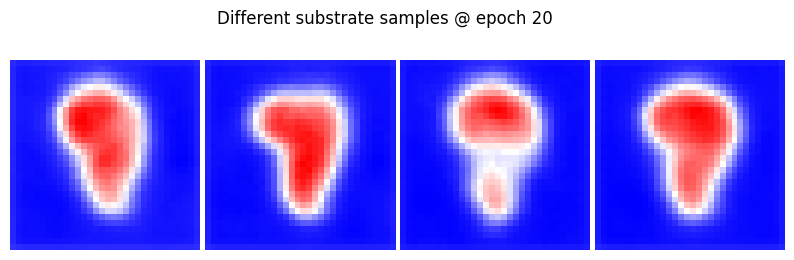

Epoch 21: train=0.6331, val=0.6177
Epoch 22: train=0.6321, val=0.6318
Epoch 23: train=0.6364, val=0.6399
Epoch 24: train=0.6330, val=0.6280
Epoch 25: train=0.6304, val=0.6244
Epoch 26: train=0.6245, val=0.6149
Epoch 27: train=0.6283, val=0.6362
Epoch 28: train=0.6280, val=0.6223
Epoch 29: train=0.6181, val=0.6195
Epoch 30: train=0.6214, val=0.6014
Epoch 31: train=0.6192, val=0.6153
Epoch 32: train=0.6173, val=0.6087
Epoch 33: train=0.6165, val=0.6223
Epoch 34: train=0.6074, val=0.6087
Epoch 35: train=0.6166, val=0.6177
Epoch 36: train=0.6117, val=0.6220
Epoch 37: train=0.6065, val=0.5902
Epoch 38: train=0.6093, val=0.5935
Epoch 39: train=0.6116, val=0.5979
Epoch 40: train=0.6042, val=0.5994
torch.Size([32, 1, 32, 32])


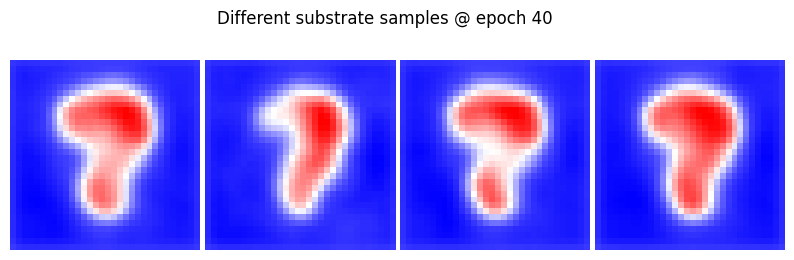

Epoch 41: train=0.5983, val=0.6036
Epoch 42: train=0.6005, val=0.5973
Epoch 43: train=0.5993, val=0.6045
Epoch 44: train=0.5852, val=0.5919
Epoch 45: train=0.5968, val=0.5820
Epoch 46: train=0.5810, val=0.5795
Epoch 47: train=0.5994, val=0.5846
Epoch 48: train=0.5847, val=0.6042
Epoch 49: train=0.5894, val=0.5770
Epoch 50: train=0.5866, val=0.5907
Epoch 51: train=0.5856, val=0.5856
Epoch 52: train=0.5846, val=0.5803
Epoch 53: train=0.5752, val=0.5788
Epoch 54: train=0.5743, val=0.5762
Epoch 55: train=0.5773, val=0.5667
Epoch 56: train=0.5643, val=0.5731
Epoch 57: train=0.5672, val=0.5786
Epoch 58: train=0.5707, val=0.5706
Epoch 59: train=0.5590, val=0.5713
Epoch 60: train=0.5757, val=0.5628
torch.Size([32, 1, 32, 32])


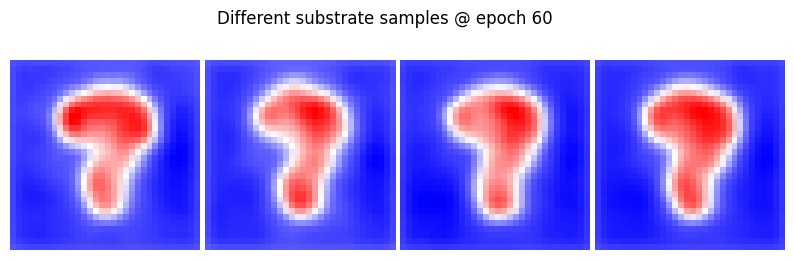

Epoch 61: train=0.5665, val=0.5719
Epoch 62: train=0.5634, val=0.5885
Epoch 63: train=0.5594, val=0.5723
Epoch 64: train=0.5674, val=0.5568
Epoch 65: train=0.5641, val=0.5627
Epoch 66: train=0.5642, val=0.5565
Epoch 67: train=0.5578, val=0.5539
Epoch 68: train=0.5619, val=0.5461
Epoch 69: train=0.5504, val=0.5527
Epoch 70: train=0.5556, val=0.5417
Epoch 71: train=0.5467, val=0.5657
Epoch 72: train=0.5462, val=0.5512
Epoch 73: train=0.5478, val=0.5512
Epoch 74: train=0.5464, val=0.5588
Epoch 75: train=0.5347, val=0.5452
Epoch 76: train=0.5451, val=0.5464
Epoch 77: train=0.5480, val=0.5411
Epoch 78: train=0.5329, val=0.5421
Epoch 79: train=0.5467, val=0.5391
Epoch 80: train=0.5294, val=0.5598
torch.Size([32, 1, 32, 32])


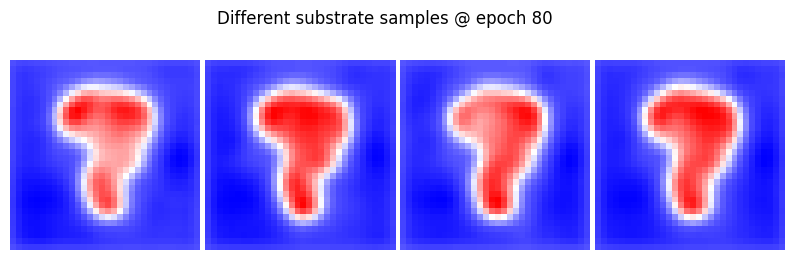

Epoch 81: train=0.5356, val=0.5348
Epoch 82: train=0.5226, val=0.5457
Epoch 83: train=0.5317, val=0.5390
Epoch 84: train=0.5339, val=0.5257
Epoch 85: train=0.5462, val=0.5252
Epoch 86: train=0.5367, val=0.5396
Epoch 87: train=0.5291, val=0.5291
Epoch 88: train=0.5372, val=0.5327
Epoch 89: train=0.5242, val=0.5263
Epoch 90: train=0.5194, val=0.5462
Epoch 91: train=0.5384, val=0.5245
Epoch 92: train=0.5175, val=0.5189
Epoch 93: train=0.5226, val=0.5301
Epoch 94: train=0.5223, val=0.5262
Epoch 95: train=0.5303, val=0.5236
Epoch 96: train=0.5217, val=0.5182
Epoch 97: train=0.5250, val=0.5217
Epoch 98: train=0.5185, val=0.5203
Epoch 99: train=0.5158, val=0.5153
Epoch 100: train=0.5117, val=0.5295
torch.Size([32, 1, 32, 32])


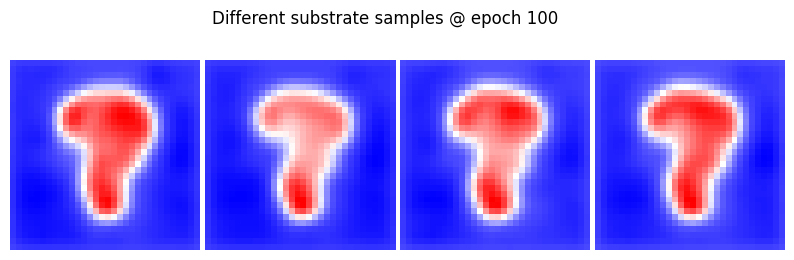

Epoch 101: train=0.5071, val=0.5158
Epoch 102: train=0.5134, val=0.5217
Epoch 103: train=0.5129, val=0.5197
Epoch 104: train=0.5036, val=0.5087
Epoch 105: train=0.5043, val=0.5059
Epoch 106: train=0.5149, val=0.4944
Epoch 107: train=0.5088, val=0.5010
Epoch 108: train=0.5016, val=0.5163
Epoch 109: train=0.5022, val=0.5069
Epoch 110: train=0.5055, val=0.5095
Epoch 111: train=0.5031, val=0.5075
Epoch 112: train=0.5041, val=0.5007
Epoch 113: train=0.5001, val=0.5032
Epoch 114: train=0.5003, val=0.5122
Epoch 115: train=0.5000, val=0.5053
Epoch 116: train=0.5023, val=0.4962
Epoch 117: train=0.4963, val=0.4968
Epoch 118: train=0.4969, val=0.4990
Epoch 119: train=0.4882, val=0.4928
Epoch 120: train=0.4817, val=0.4896
torch.Size([32, 1, 32, 32])


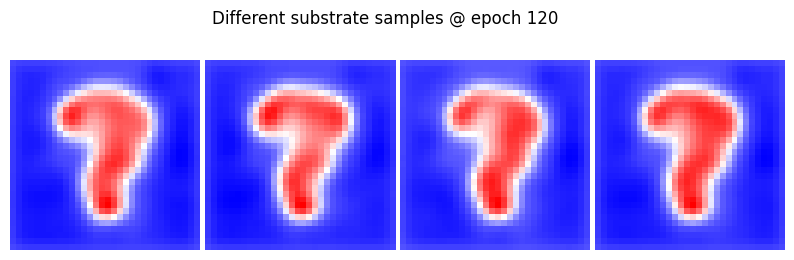

Epoch 121: train=0.4958, val=0.5012
Epoch 122: train=0.4903, val=0.4948
Epoch 123: train=0.4993, val=0.4863
Epoch 124: train=0.4987, val=0.4814
Epoch 125: train=0.4953, val=0.4794
Epoch 126: train=0.4887, val=0.4822
Epoch 127: train=0.4838, val=0.4928
Epoch 128: train=0.4848, val=0.4829
Epoch 129: train=0.4844, val=0.4870
Epoch 130: train=0.4769, val=0.4836
Epoch 131: train=0.4730, val=0.4842
Epoch 132: train=0.4871, val=0.4953
Epoch 133: train=0.4852, val=0.4713
Epoch 134: train=0.4911, val=0.4884
Epoch 135: train=0.4775, val=0.4733
Epoch 136: train=0.4766, val=0.4722
Epoch 137: train=0.4675, val=0.4771
Epoch 138: train=0.4795, val=0.4788
Epoch 139: train=0.4627, val=0.4854
Epoch 140: train=0.4746, val=0.4652
torch.Size([32, 1, 32, 32])


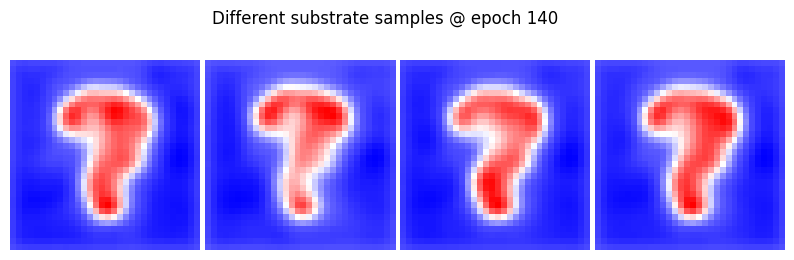

Epoch 141: train=0.4727, val=0.4884
Epoch 142: train=0.4656, val=0.4720
Epoch 143: train=0.4635, val=0.4714
Epoch 144: train=0.4690, val=0.4737
Epoch 145: train=0.4655, val=0.4741
Epoch 146: train=0.4578, val=0.4863
Epoch 147: train=0.4658, val=0.4708
Epoch 148: train=0.4627, val=0.4666
Epoch 149: train=0.4691, val=0.4714
Epoch 150: train=0.4552, val=0.4695
Epoch 151: train=0.4678, val=0.4620
Epoch 152: train=0.4637, val=0.4567
Epoch 153: train=0.4540, val=0.4646
Epoch 154: train=0.4418, val=0.4524
Epoch 155: train=0.4530, val=0.4666
Epoch 156: train=0.4599, val=0.4540
Epoch 157: train=0.4477, val=0.4633
Epoch 158: train=0.4559, val=0.4428
Epoch 159: train=0.4435, val=0.4529
Epoch 160: train=0.4579, val=0.4607
torch.Size([32, 1, 32, 32])


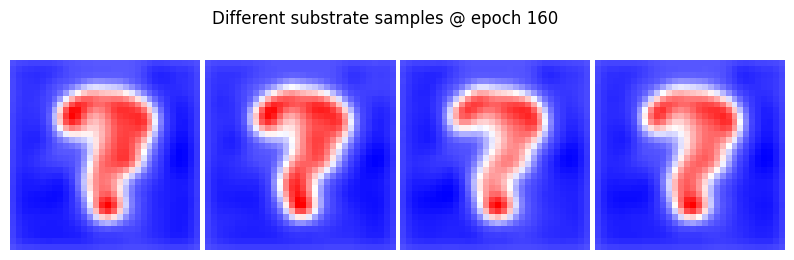

Epoch 161: train=0.4544, val=0.4522
Epoch 162: train=0.4503, val=0.4580
Epoch 163: train=0.4462, val=0.4728
Epoch 164: train=0.4473, val=0.4526
Epoch 165: train=0.4546, val=0.4495
Epoch 166: train=0.4459, val=0.4531
Epoch 167: train=0.4404, val=0.4597
Epoch 168: train=0.4445, val=0.4547
Epoch 169: train=0.4377, val=0.4311
Epoch 170: train=0.4378, val=0.4407
Epoch 171: train=0.4381, val=0.4347
Epoch 172: train=0.4409, val=0.4480
Epoch 173: train=0.4344, val=0.4412
Epoch 174: train=0.4296, val=0.4366
Epoch 175: train=0.4392, val=0.4347
Epoch 176: train=0.4409, val=0.4340
Epoch 177: train=0.4480, val=0.4381
Epoch 178: train=0.4312, val=0.4316
Epoch 179: train=0.4336, val=0.4503
Epoch 180: train=0.4346, val=0.4313
torch.Size([32, 1, 32, 32])


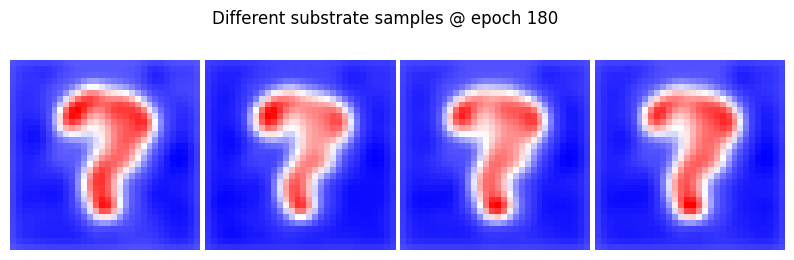

Epoch 181: train=0.4298, val=0.4372
Epoch 182: train=0.4250, val=0.4345
Epoch 183: train=0.4437, val=0.4217
Epoch 184: train=0.4206, val=0.4329
Epoch 185: train=0.4269, val=0.4306
Epoch 186: train=0.4165, val=0.4163
Epoch 187: train=0.4145, val=0.4110
Epoch 188: train=0.4288, val=0.4304
Epoch 189: train=0.4361, val=0.4206
Epoch 190: train=0.4166, val=0.4233
Epoch 191: train=0.4213, val=0.4185
Epoch 192: train=0.4153, val=0.4146
Epoch 193: train=0.4253, val=0.4376
Epoch 194: train=0.4324, val=0.4156
Epoch 195: train=0.4198, val=0.4150
Epoch 196: train=0.4381, val=0.4158
Epoch 197: train=0.4208, val=0.4111
Epoch 198: train=0.4192, val=0.4064
Epoch 199: train=0.4183, val=0.4222
Epoch 200: train=0.4262, val=0.4170
torch.Size([32, 1, 32, 32])


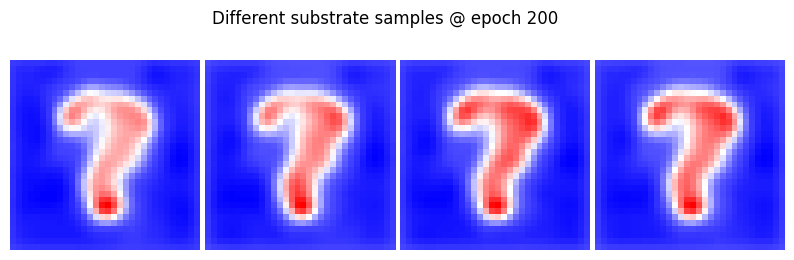

Epoch 201: train=0.4142, val=0.4244
Epoch 202: train=0.4157, val=0.4079
Epoch 203: train=0.4115, val=0.4080
Epoch 204: train=0.4124, val=0.4242
Epoch 205: train=0.4079, val=0.4237
Epoch 206: train=0.4108, val=0.4219
Epoch 207: train=0.4079, val=0.4021
Epoch 208: train=0.4074, val=0.4164
Epoch 209: train=0.4044, val=0.4132
Epoch 210: train=0.4011, val=0.4063
Epoch 211: train=0.4147, val=0.4024
Epoch 212: train=0.3903, val=0.4101
Epoch 213: train=0.4035, val=0.3976
Epoch 214: train=0.4192, val=0.4008
Epoch 215: train=0.4108, val=0.3903
Epoch 216: train=0.3974, val=0.3936
Epoch 217: train=0.4126, val=0.3998
Epoch 218: train=0.3832, val=0.4091
Epoch 219: train=0.3907, val=0.3961
Epoch 220: train=0.4012, val=0.4080
torch.Size([32, 1, 32, 32])


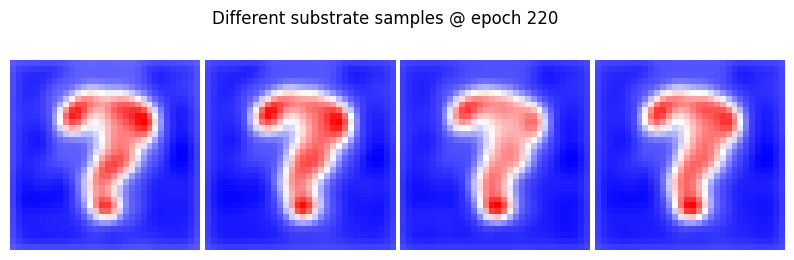

Epoch 221: train=0.4003, val=0.4085
Epoch 222: train=0.3977, val=0.4003
Epoch 223: train=0.4160, val=0.3988
Epoch 224: train=0.3924, val=0.3857
Epoch 225: train=0.3797, val=0.3760
Epoch 226: train=0.3825, val=0.3923
Epoch 227: train=0.3863, val=0.4064
Epoch 228: train=0.3885, val=0.3834
Epoch 229: train=0.3800, val=0.3915
Epoch 230: train=0.3968, val=0.3841
Epoch 231: train=0.3990, val=0.3886
Epoch 232: train=0.3850, val=0.4037
Epoch 233: train=0.3880, val=0.3798
Epoch 234: train=0.3894, val=0.3978
Epoch 235: train=0.3958, val=0.3891
Epoch 236: train=0.3919, val=0.3790
Epoch 237: train=0.3803, val=0.3639
Epoch 238: train=0.3767, val=0.4033
Epoch 239: train=0.3838, val=0.3650
Epoch 240: train=0.3847, val=0.3888
torch.Size([32, 1, 32, 32])


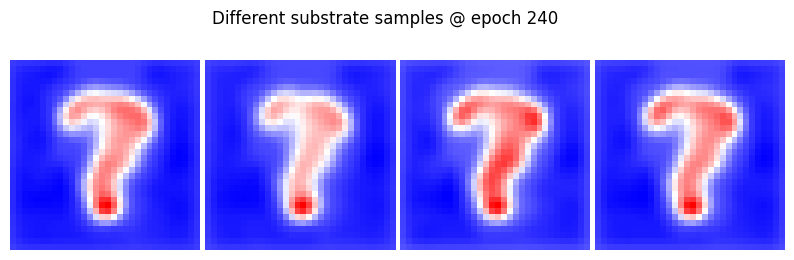

Epoch 241: train=0.4141, val=0.3779
Epoch 242: train=0.3835, val=0.3692
Epoch 243: train=0.3717, val=0.3821
Epoch 244: train=0.3750, val=0.3821
Epoch 245: train=0.3765, val=0.3911
Epoch 246: train=0.3617, val=0.3813
Epoch 247: train=0.3680, val=0.3685
Epoch 248: train=0.3748, val=0.3826
Epoch 249: train=0.3636, val=0.3676
Epoch 250: train=0.3760, val=0.3633
Epoch 251: train=0.3625, val=0.3686
Epoch 252: train=0.3651, val=0.3681
Epoch 253: train=0.3763, val=0.3748
Epoch 254: train=0.3700, val=0.3678
Epoch 255: train=0.3732, val=0.3717
Epoch 256: train=0.3630, val=0.3718
Epoch 257: train=0.3572, val=0.3715
Epoch 258: train=0.3608, val=0.3474
Epoch 259: train=0.3721, val=0.3719
Epoch 260: train=0.3579, val=0.3538
torch.Size([32, 1, 32, 32])


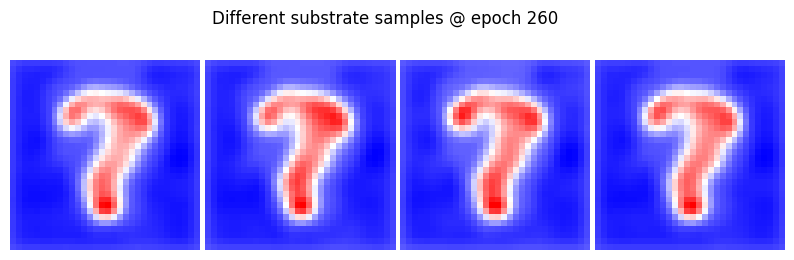

Epoch 261: train=0.3716, val=0.3638
Epoch 262: train=0.3574, val=0.3628
Epoch 263: train=0.3602, val=0.3565
Epoch 264: train=0.3654, val=0.3662
Epoch 265: train=0.3598, val=0.3528
Epoch 266: train=0.3704, val=0.3513
Epoch 267: train=0.3558, val=0.3352
Epoch 268: train=0.3454, val=0.3532
Epoch 269: train=0.3664, val=0.3590
Epoch 270: train=0.3494, val=0.3698
Epoch 271: train=0.3702, val=0.3727
Epoch 272: train=0.3584, val=0.3425
Epoch 273: train=0.3552, val=0.3687
Epoch 274: train=0.3445, val=0.3512
Epoch 275: train=0.3503, val=0.3420
Epoch 276: train=0.3578, val=0.3401
Epoch 277: train=0.3566, val=0.3516
Epoch 278: train=0.3598, val=0.3615
Epoch 279: train=0.3468, val=0.3475
Epoch 280: train=0.3393, val=0.3514
torch.Size([32, 1, 32, 32])


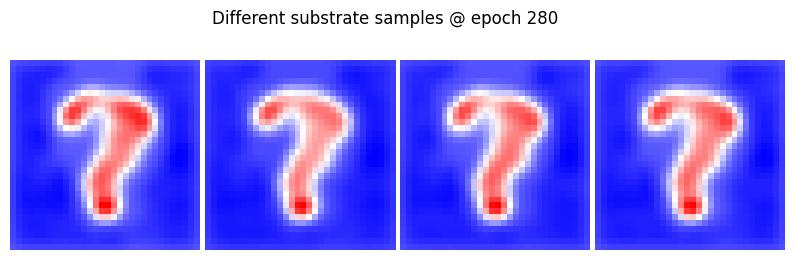

Epoch 281: train=0.3404, val=0.3447
Epoch 282: train=0.3569, val=0.3507
Epoch 283: train=0.3504, val=0.3426
Epoch 284: train=0.3371, val=0.3358
Epoch 285: train=0.3390, val=0.3329
Epoch 286: train=0.3361, val=0.3353
Epoch 287: train=0.3480, val=0.3711
Epoch 288: train=0.3406, val=0.3417
Epoch 289: train=0.3554, val=0.3398
Epoch 290: train=0.3449, val=0.3520
Epoch 291: train=0.3331, val=0.3338
Epoch 292: train=0.3357, val=0.3312
Epoch 293: train=0.3289, val=0.3260
Epoch 294: train=0.3442, val=0.3232
Epoch 295: train=0.3401, val=0.3268
Epoch 296: train=0.3325, val=0.3461
Epoch 297: train=0.3211, val=0.3504
Epoch 298: train=0.3225, val=0.3439
Epoch 299: train=0.3448, val=0.3377
Epoch 300: train=0.3269, val=0.3255
torch.Size([32, 1, 32, 32])


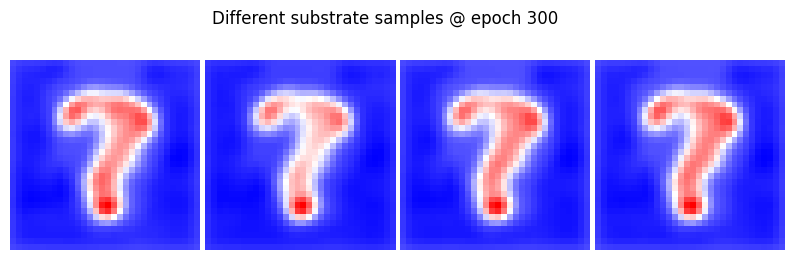

Epoch 301: train=0.3277, val=0.3250
Epoch 302: train=0.3491, val=0.3249
Epoch 303: train=0.3234, val=0.3433
Epoch 304: train=0.3288, val=0.3408
Epoch 305: train=0.3297, val=0.3205
Epoch 306: train=0.3418, val=0.3343
Epoch 307: train=0.3279, val=0.3228
Epoch 308: train=0.3245, val=0.3226
Epoch 309: train=0.3189, val=0.3297
Epoch 310: train=0.3168, val=0.3185
Epoch 311: train=0.3373, val=0.3170
Epoch 312: train=0.3253, val=0.3260
Epoch 313: train=0.3367, val=0.3327
Epoch 314: train=0.3235, val=0.3356
Epoch 315: train=0.3224, val=0.3126
Epoch 316: train=0.3244, val=0.3024
Epoch 317: train=0.3212, val=0.3184
Epoch 318: train=0.3129, val=0.3127
Epoch 319: train=0.3155, val=0.3119
Epoch 320: train=0.3097, val=0.3206
torch.Size([32, 1, 32, 32])


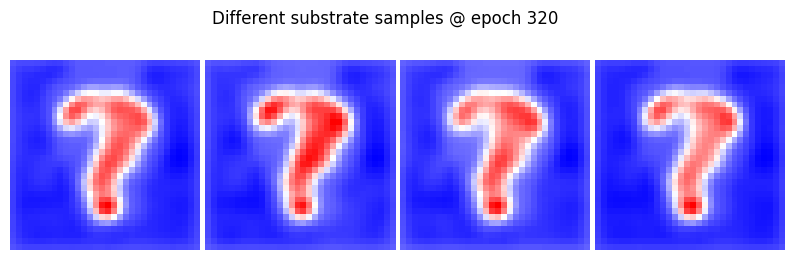

Epoch 321: train=0.3050, val=0.3327
Epoch 322: train=0.3359, val=0.3087
Epoch 323: train=0.3144, val=0.3184
Epoch 324: train=0.3219, val=0.3173
Epoch 325: train=0.3091, val=0.3070
Epoch 326: train=0.3204, val=0.3174
Epoch 327: train=0.3161, val=0.3190
Epoch 328: train=0.3240, val=0.3129
Epoch 329: train=0.3252, val=0.3179
Epoch 330: train=0.3152, val=0.3055
Epoch 331: train=0.3117, val=0.3130
Epoch 332: train=0.3211, val=0.2970
Epoch 333: train=0.3123, val=0.3078
Epoch 334: train=0.3116, val=0.3038
Epoch 335: train=0.3051, val=0.2994
Epoch 336: train=0.3041, val=0.2920
Epoch 337: train=0.3017, val=0.2953
Epoch 338: train=0.3093, val=0.3130
Epoch 339: train=0.3014, val=0.2927
Epoch 340: train=0.2923, val=0.2958
torch.Size([32, 1, 32, 32])


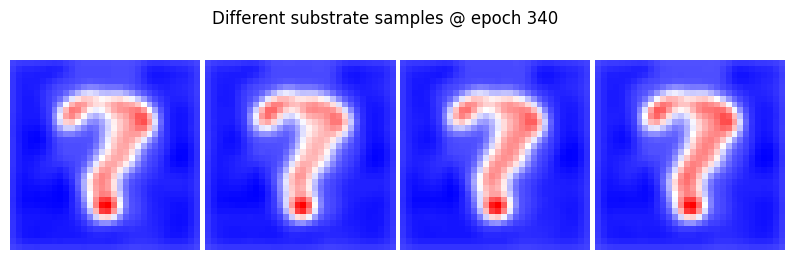

Epoch 341: train=0.3037, val=0.2947
Epoch 342: train=0.3072, val=0.3080
Epoch 343: train=0.2961, val=0.2881
Epoch 344: train=0.2972, val=0.3065
Epoch 345: train=0.2971, val=0.3058
Epoch 346: train=0.3028, val=0.3001
Epoch 347: train=0.3051, val=0.2991
Epoch 348: train=0.3003, val=0.3262
Epoch 349: train=0.3255, val=0.2994
Epoch 350: train=0.2954, val=0.2833
Epoch 351: train=0.2976, val=0.3025
Epoch 352: train=0.2924, val=0.2849
Epoch 353: train=0.3077, val=0.3095
Epoch 354: train=0.2987, val=0.3099
Epoch 355: train=0.2955, val=0.3155
Epoch 356: train=0.2924, val=0.2944
Epoch 357: train=0.2932, val=0.3016
Epoch 358: train=0.3110, val=0.2853
Epoch 359: train=0.3044, val=0.2803
Epoch 360: train=0.2816, val=0.3020
torch.Size([32, 1, 32, 32])


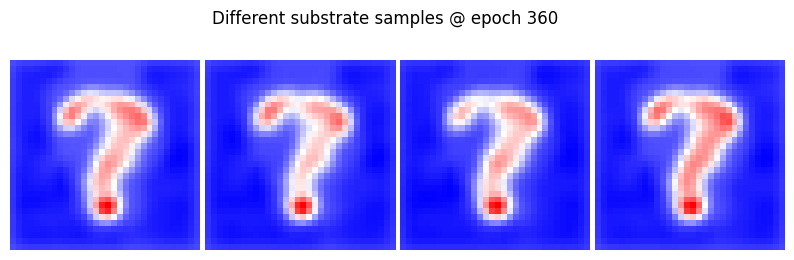

Epoch 361: train=0.2863, val=0.2815
Epoch 362: train=0.2991, val=0.2840
Epoch 363: train=0.2787, val=0.3011
Epoch 364: train=0.2846, val=0.2833
Epoch 365: train=0.2884, val=0.2913
Epoch 366: train=0.2932, val=0.2729
Epoch 367: train=0.2874, val=0.2758
Epoch 368: train=0.2813, val=0.2865
Epoch 369: train=0.2788, val=0.2761
Epoch 370: train=0.2778, val=0.2885
Epoch 371: train=0.2781, val=0.2920
Epoch 372: train=0.2879, val=0.2768
Epoch 373: train=0.2815, val=0.2725
Epoch 374: train=0.2866, val=0.2788
Epoch 375: train=0.2918, val=0.2799
Epoch 376: train=0.2764, val=0.2833
Epoch 377: train=0.2901, val=0.2757
Epoch 378: train=0.2826, val=0.2765
Epoch 379: train=0.2880, val=0.2767
Epoch 380: train=0.2799, val=0.2714
torch.Size([32, 1, 32, 32])


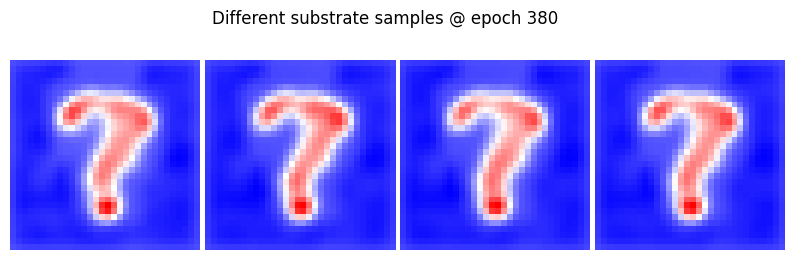

Epoch 381: train=0.2685, val=0.2838
Epoch 382: train=0.2881, val=0.2927
Epoch 383: train=0.2717, val=0.2559
Epoch 384: train=0.2778, val=0.2690
Epoch 385: train=0.2711, val=0.2659
Epoch 386: train=0.2805, val=0.2736
Epoch 387: train=0.2824, val=0.2688
Epoch 388: train=0.2816, val=0.2897
Epoch 389: train=0.2644, val=0.2736
Epoch 390: train=0.2682, val=0.2650
Epoch 391: train=0.2799, val=0.2856
Epoch 392: train=0.2783, val=0.2818
Epoch 393: train=0.2885, val=0.2722
Epoch 394: train=0.2674, val=0.2787
Epoch 395: train=0.2786, val=0.2764
Epoch 396: train=0.2806, val=0.2674
Epoch 397: train=0.2669, val=0.2538
Epoch 398: train=0.2773, val=0.2718
Epoch 399: train=0.2656, val=0.2569
Epoch 400: train=0.2744, val=0.2613
torch.Size([32, 1, 32, 32])


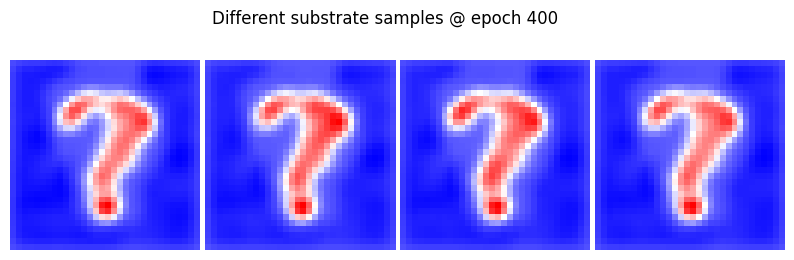

Epoch 401: train=0.2564, val=0.2636
Epoch 402: train=0.2623, val=0.2637
Epoch 403: train=0.2689, val=0.2598
Epoch 404: train=0.2566, val=0.2784
Epoch 405: train=0.2727, val=0.2679
Epoch 406: train=0.2629, val=0.2655
Epoch 407: train=0.2623, val=0.2625
Epoch 408: train=0.2559, val=0.2715
Epoch 409: train=0.2667, val=0.2555
Epoch 410: train=0.2552, val=0.2553
Epoch 411: train=0.2813, val=0.2492
Epoch 412: train=0.2562, val=0.2554
Epoch 413: train=0.2701, val=0.2541
Epoch 414: train=0.2680, val=0.2678
Epoch 415: train=0.2614, val=0.2501
Epoch 416: train=0.2670, val=0.2692
Epoch 417: train=0.2527, val=0.2667
Epoch 418: train=0.2525, val=0.2489
Epoch 419: train=0.2608, val=0.2576
Epoch 420: train=0.2539, val=0.2562
torch.Size([32, 1, 32, 32])


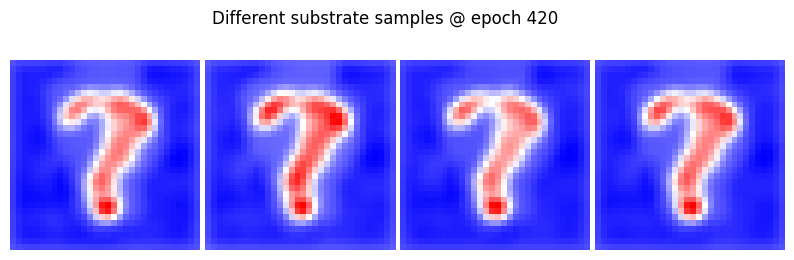

Epoch 421: train=0.2548, val=0.2477
Epoch 422: train=0.2477, val=0.2488
Epoch 423: train=0.2703, val=0.2505
Epoch 424: train=0.2690, val=0.2447
Epoch 425: train=0.2639, val=0.2462
Epoch 426: train=0.2501, val=0.2595
Epoch 427: train=0.2429, val=0.2531
Epoch 428: train=0.2422, val=0.2459
Epoch 429: train=0.2551, val=0.2702
Epoch 430: train=0.2411, val=0.2343
Epoch 431: train=0.2664, val=0.2343
Epoch 432: train=0.2420, val=0.2393
Epoch 433: train=0.2489, val=0.2506
Epoch 434: train=0.2513, val=0.2533
Epoch 435: train=0.2559, val=0.2380
Epoch 436: train=0.2381, val=0.2488
Epoch 437: train=0.2531, val=0.2519
Epoch 438: train=0.2385, val=0.2443
Epoch 439: train=0.2379, val=0.2321
Epoch 440: train=0.2403, val=0.2464
torch.Size([32, 1, 32, 32])


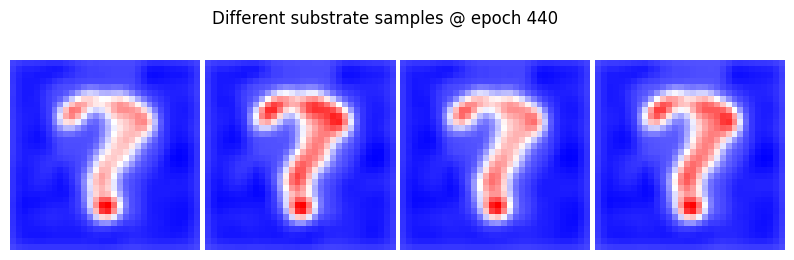

Epoch 441: train=0.2458, val=0.2419
Epoch 442: train=0.2598, val=0.2336
Epoch 443: train=0.2410, val=0.2290
Epoch 444: train=0.2344, val=0.2299
Epoch 445: train=0.2551, val=0.2334
Epoch 446: train=0.2430, val=0.2417
Epoch 447: train=0.2512, val=0.2272
Epoch 448: train=0.2416, val=0.2325
Epoch 449: train=0.2360, val=0.2295
Epoch 450: train=0.2401, val=0.2350
Epoch 451: train=0.2475, val=0.2281
Epoch 452: train=0.2376, val=0.2263
Epoch 453: train=0.2292, val=0.2571
Epoch 454: train=0.2503, val=0.2473
Epoch 455: train=0.2264, val=0.2355
Epoch 456: train=0.2303, val=0.2442
Epoch 457: train=0.2322, val=0.2210
Epoch 458: train=0.2389, val=0.2241
Epoch 459: train=0.2370, val=0.2350
Epoch 460: train=0.2295, val=0.2281
torch.Size([32, 1, 32, 32])


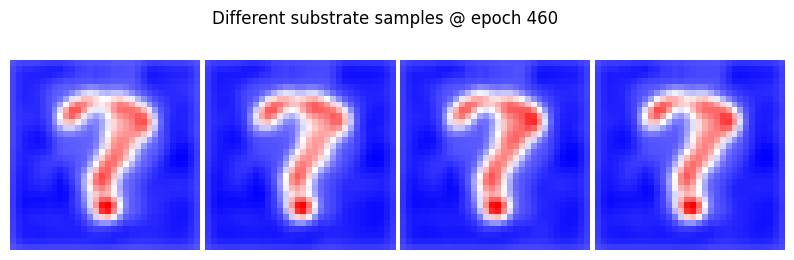

Epoch 461: train=0.2336, val=0.2292
Epoch 462: train=0.2341, val=0.2354
Epoch 463: train=0.2284, val=0.2225
Epoch 464: train=0.2235, val=0.2199
Epoch 465: train=0.2239, val=0.2254
Epoch 466: train=0.2394, val=0.2326
Epoch 467: train=0.2397, val=0.2303
Epoch 468: train=0.2224, val=0.2316
Epoch 469: train=0.2246, val=0.2168
Epoch 470: train=0.2403, val=0.2247
Epoch 471: train=0.2298, val=0.2155
Epoch 472: train=0.2234, val=0.2335
Epoch 473: train=0.2195, val=0.2292
Epoch 474: train=0.2194, val=0.2354
Epoch 475: train=0.2247, val=0.2239
Epoch 476: train=0.2222, val=0.2252
Epoch 477: train=0.2201, val=0.2331
Epoch 478: train=0.2136, val=0.2437
Epoch 479: train=0.2240, val=0.2172
Epoch 480: train=0.2313, val=0.2382
torch.Size([32, 1, 32, 32])


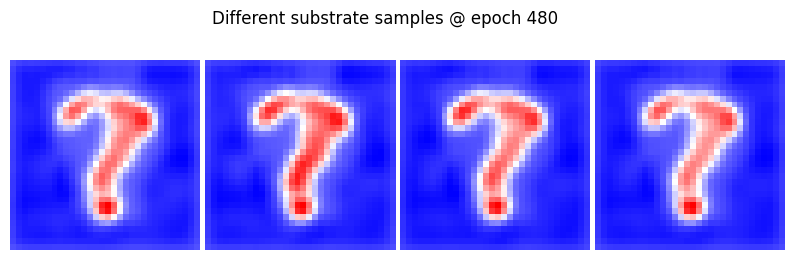

Epoch 481: train=0.2161, val=0.2269
Epoch 482: train=0.2195, val=0.2229
Epoch 483: train=0.2292, val=0.2159
Epoch 484: train=0.2161, val=0.2031
Epoch 485: train=0.2149, val=0.2136
Epoch 486: train=0.2264, val=0.2208
Epoch 487: train=0.2242, val=0.2314
Epoch 488: train=0.2356, val=0.2252
Epoch 489: train=0.2285, val=0.2120
Epoch 490: train=0.2163, val=0.2014
Epoch 491: train=0.2164, val=0.2138
Epoch 492: train=0.2146, val=0.2198
Epoch 493: train=0.2160, val=0.2092
Epoch 494: train=0.2265, val=0.2177
Epoch 495: train=0.2148, val=0.2108
Epoch 496: train=0.2085, val=0.2135
Epoch 497: train=0.2066, val=0.2272
Epoch 498: train=0.2174, val=0.2099
Epoch 499: train=0.2120, val=0.2087
Epoch 500: train=0.2112, val=0.2123
torch.Size([32, 1, 32, 32])


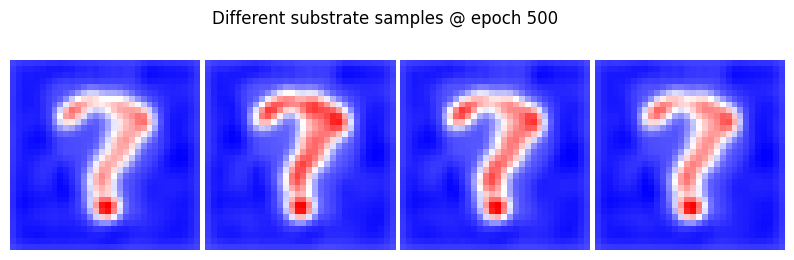

Epoch 501: train=0.2112, val=0.2092
Epoch 502: train=0.2232, val=0.2072
Epoch 503: train=0.2076, val=0.2158
Epoch 504: train=0.2075, val=0.1993
Epoch 505: train=0.2112, val=0.2003
Epoch 506: train=0.2085, val=0.2067
Epoch 507: train=0.2033, val=0.2237
Epoch 508: train=0.2042, val=0.2138
Epoch 509: train=0.2058, val=0.2211
Epoch 510: train=0.2047, val=0.2197
Epoch 511: train=0.2088, val=0.2070
Epoch 512: train=0.2221, val=0.2096
Epoch 513: train=0.2023, val=0.2033
Epoch 514: train=0.2013, val=0.2160
Epoch 515: train=0.2144, val=0.2037
Epoch 516: train=0.2036, val=0.2099
Epoch 517: train=0.2026, val=0.2126
Epoch 518: train=0.2249, val=0.2000
Epoch 519: train=0.2078, val=0.2063
Epoch 520: train=0.2129, val=0.2169
torch.Size([32, 1, 32, 32])


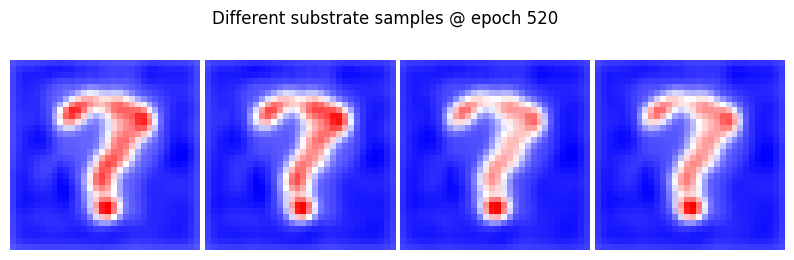

Epoch 521: train=0.2019, val=0.2155
Epoch 522: train=0.1980, val=0.2023
Epoch 523: train=0.2091, val=0.2024
Epoch 524: train=0.2089, val=0.2020
Epoch 525: train=0.2026, val=0.2068
Epoch 526: train=0.2017, val=0.1999
Epoch 527: train=0.2040, val=0.2055
Epoch 528: train=0.1923, val=0.1927
Epoch 529: train=0.2095, val=0.1890
Epoch 530: train=0.1946, val=0.2015
Epoch 531: train=0.2019, val=0.1968
Epoch 532: train=0.2099, val=0.1914
Epoch 533: train=0.1993, val=0.1986
Epoch 534: train=0.1948, val=0.2013
Epoch 535: train=0.1948, val=0.2040
Epoch 536: train=0.1964, val=0.1903
Epoch 537: train=0.1903, val=0.2009
Epoch 538: train=0.2114, val=0.1897
Epoch 539: train=0.2207, val=0.1838
Epoch 540: train=0.1933, val=0.1981
torch.Size([32, 1, 32, 32])


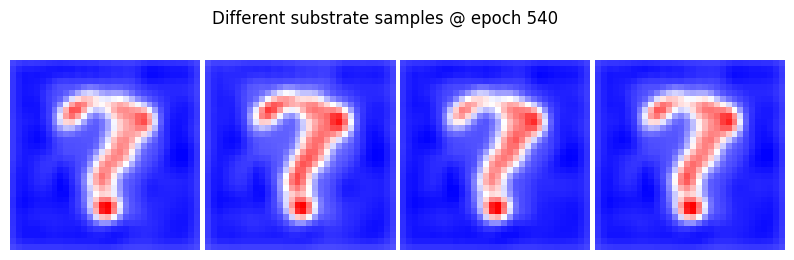

Epoch 541: train=0.2048, val=0.1889
Epoch 542: train=0.1892, val=0.1842
Epoch 543: train=0.1902, val=0.1822
Epoch 544: train=0.1949, val=0.2006
Epoch 545: train=0.1902, val=0.1837
Epoch 546: train=0.1904, val=0.1763
Epoch 547: train=0.1869, val=0.1957
Epoch 548: train=0.1842, val=0.1940
Epoch 549: train=0.2014, val=0.2149
Epoch 550: train=0.1897, val=0.2037
Epoch 551: train=0.1836, val=0.1942
Epoch 552: train=0.1814, val=0.1900
Epoch 553: train=0.1843, val=0.1957
Epoch 554: train=0.1881, val=0.1908
Epoch 555: train=0.1824, val=0.1837
Epoch 556: train=0.1924, val=0.1867
Epoch 557: train=0.1898, val=0.1853
Epoch 558: train=0.1843, val=0.1903
Epoch 559: train=0.1799, val=0.1828
Epoch 560: train=0.1891, val=0.1848
torch.Size([32, 1, 32, 32])


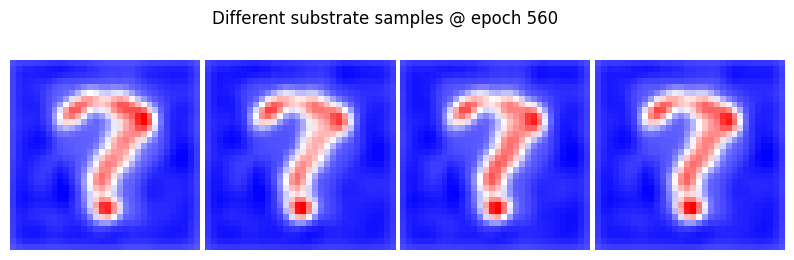

Epoch 561: train=0.1846, val=0.1804
Epoch 562: train=0.1784, val=0.1795
Epoch 563: train=0.1801, val=0.1776
Epoch 564: train=0.1783, val=0.1985
Epoch 565: train=0.1797, val=0.1904
Epoch 566: train=0.1870, val=0.1850
Epoch 567: train=0.1822, val=0.1821
Epoch 568: train=0.1803, val=0.1840
Epoch 569: train=0.1833, val=0.1890
Epoch 570: train=0.1753, val=0.1746
Epoch 571: train=0.1825, val=0.1897
Epoch 572: train=0.1769, val=0.1785
Epoch 573: train=0.1866, val=0.1714
Epoch 574: train=0.1919, val=0.1805
Epoch 575: train=0.1759, val=0.1944
Epoch 576: train=0.1844, val=0.1853
Epoch 577: train=0.1862, val=0.1674
Epoch 578: train=0.1715, val=0.1820
Epoch 579: train=0.1813, val=0.1732
Epoch 580: train=0.1844, val=0.1840
torch.Size([32, 1, 32, 32])


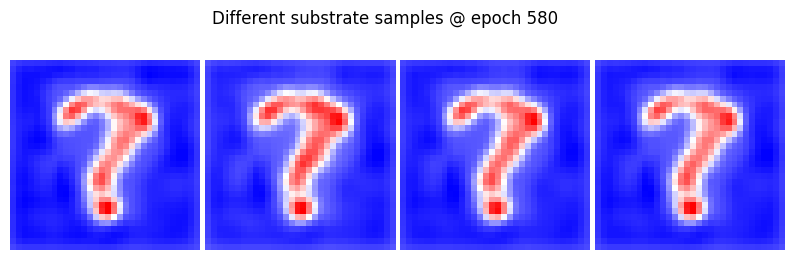

Epoch 581: train=0.1748, val=0.1718
Epoch 582: train=0.1740, val=0.1745
Epoch 583: train=0.2020, val=0.1926
Epoch 584: train=0.1765, val=0.1866
Epoch 585: train=0.1727, val=0.1703
Epoch 586: train=0.1686, val=0.1804
Epoch 587: train=0.1731, val=0.1753
Epoch 588: train=0.1759, val=0.1855
Epoch 589: train=0.1717, val=0.1739
Epoch 590: train=0.1819, val=0.1646
Epoch 591: train=0.1724, val=0.1938
Epoch 592: train=0.1858, val=0.1673
Epoch 593: train=0.1802, val=0.1880
Epoch 594: train=0.1874, val=0.1653
Epoch 595: train=0.1708, val=0.1690
Epoch 596: train=0.1722, val=0.1666
Epoch 597: train=0.1716, val=0.1656
Epoch 598: train=0.1727, val=0.1694
Epoch 599: train=0.1791, val=0.1686
Epoch 600: train=0.1667, val=0.1865
torch.Size([32, 1, 32, 32])


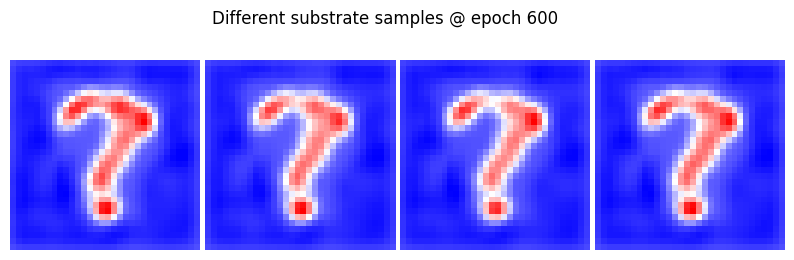

Epoch 601: train=0.1666, val=0.1757
Epoch 602: train=0.1652, val=0.1690
Epoch 603: train=0.1781, val=0.1704
Epoch 604: train=0.1773, val=0.1751
Epoch 605: train=0.1775, val=0.1734
Epoch 606: train=0.1726, val=0.1648
Epoch 607: train=0.1782, val=0.1625
Epoch 608: train=0.1674, val=0.1598
Epoch 609: train=0.1752, val=0.1581
Epoch 610: train=0.1684, val=0.1751
Epoch 611: train=0.1686, val=0.1691
Epoch 612: train=0.1713, val=0.1617
Epoch 613: train=0.1650, val=0.1626
Epoch 614: train=0.1625, val=0.1804
Epoch 615: train=0.1605, val=0.1586
Epoch 616: train=0.1708, val=0.1594
Epoch 617: train=0.1768, val=0.1659
Epoch 618: train=0.1629, val=0.1550
Epoch 619: train=0.1639, val=0.1711
Epoch 620: train=0.1589, val=0.1550
torch.Size([32, 1, 32, 32])


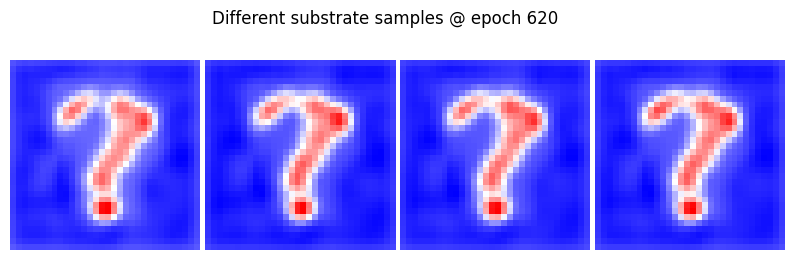

Epoch 621: train=0.1657, val=0.1656
Epoch 622: train=0.1706, val=0.1690
Epoch 623: train=0.1645, val=0.1554
Epoch 624: train=0.1591, val=0.1629
Epoch 625: train=0.1718, val=0.1672
Epoch 626: train=0.1624, val=0.1565
Epoch 627: train=0.1565, val=0.1591
Epoch 628: train=0.1564, val=0.1538
Epoch 629: train=0.1591, val=0.1527
Epoch 630: train=0.1544, val=0.1760
Epoch 631: train=0.1568, val=0.1549
Epoch 632: train=0.1567, val=0.1583
Epoch 633: train=0.1575, val=0.1558
Epoch 634: train=0.1582, val=0.1528
Epoch 635: train=0.1648, val=0.1575
Epoch 636: train=0.1548, val=0.1670
Epoch 637: train=0.1639, val=0.1663
Epoch 638: train=0.1592, val=0.1677
Epoch 639: train=0.1539, val=0.1720
Epoch 640: train=0.1580, val=0.1633
torch.Size([32, 1, 32, 32])


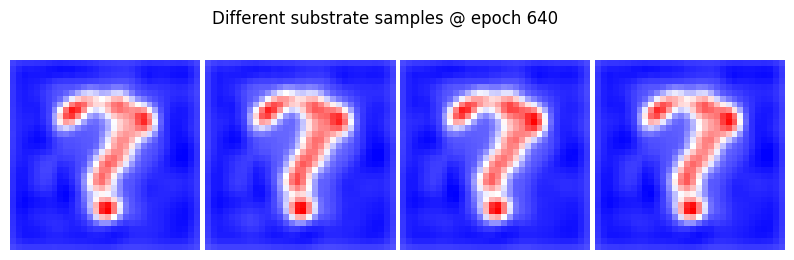

Epoch 641: train=0.1522, val=0.1531
Epoch 642: train=0.1585, val=0.1640
Epoch 643: train=0.1512, val=0.1565
Epoch 644: train=0.1706, val=0.1571
Epoch 645: train=0.1476, val=0.1715
Epoch 646: train=0.1691, val=0.1505
Epoch 647: train=0.1527, val=0.1448
Epoch 648: train=0.1553, val=0.1512
Epoch 649: train=0.1548, val=0.1677
Epoch 650: train=0.1786, val=0.1490
Epoch 651: train=0.1523, val=0.1476
Epoch 652: train=0.1519, val=0.1681
Epoch 653: train=0.1538, val=0.1376
Epoch 654: train=0.1538, val=0.1447
Epoch 655: train=0.1543, val=0.1629
Epoch 656: train=0.1576, val=0.1619
Epoch 657: train=0.1552, val=0.1483
Epoch 658: train=0.1552, val=0.1525
Epoch 659: train=0.1480, val=0.1423
Epoch 660: train=0.1531, val=0.1513
torch.Size([32, 1, 32, 32])


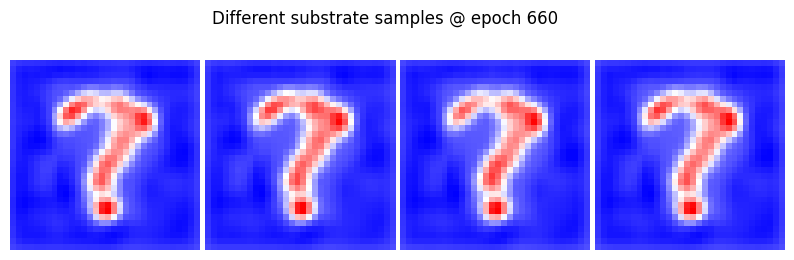

Epoch 661: train=0.1760, val=0.1521
Epoch 662: train=0.1594, val=0.1498
Epoch 663: train=0.1512, val=0.1495
Epoch 664: train=0.1511, val=0.1443
Epoch 665: train=0.1506, val=0.1565
Epoch 666: train=0.1547, val=0.1429
Epoch 667: train=0.1520, val=0.1465
Epoch 668: train=0.1537, val=0.1608
Epoch 669: train=0.1460, val=0.1492
Epoch 670: train=0.1478, val=0.1566
Epoch 671: train=0.1472, val=0.1580
Epoch 672: train=0.1473, val=0.1472
Epoch 673: train=0.1464, val=0.1392
Epoch 674: train=0.1429, val=0.1386
Epoch 675: train=0.1585, val=0.1556
Epoch 676: train=0.1467, val=0.1472
Epoch 677: train=0.1518, val=0.1545
Epoch 678: train=0.1458, val=0.1629
Epoch 679: train=0.1518, val=0.1454
Epoch 680: train=0.1604, val=0.1605
torch.Size([32, 1, 32, 32])


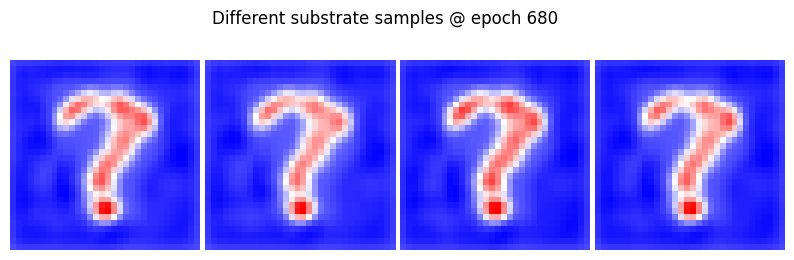

Epoch 681: train=0.1398, val=0.1413
Epoch 682: train=0.1465, val=0.1386
Epoch 683: train=0.1557, val=0.1517
Epoch 684: train=0.1428, val=0.1485
Epoch 685: train=0.1481, val=0.1304
Epoch 686: train=0.1480, val=0.1384
Epoch 687: train=0.1435, val=0.1642
Epoch 688: train=0.1499, val=0.1501
Epoch 689: train=0.1411, val=0.1485
Epoch 690: train=0.1412, val=0.1471
Epoch 691: train=0.1368, val=0.1359
Epoch 692: train=0.1416, val=0.1443
Epoch 693: train=0.1638, val=0.1454
Epoch 694: train=0.1504, val=0.1340
Epoch 695: train=0.1582, val=0.1395
Epoch 696: train=0.1485, val=0.1408
Epoch 697: train=0.1611, val=0.1429
Epoch 698: train=0.1392, val=0.1486
Epoch 699: train=0.1374, val=0.1434
Epoch 700: train=0.1446, val=0.1410
torch.Size([32, 1, 32, 32])


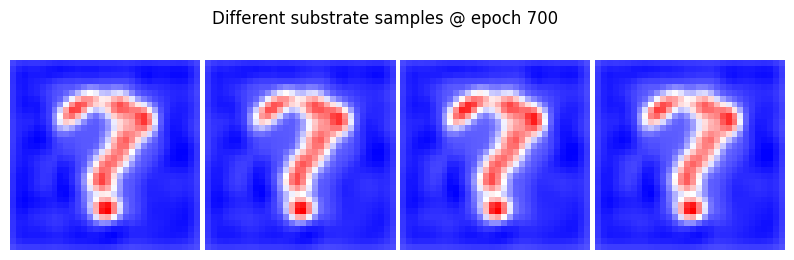

Epoch 701: train=0.1377, val=0.1392
Epoch 702: train=0.1435, val=0.1521
Epoch 703: train=0.1370, val=0.1456
Epoch 704: train=0.1448, val=0.1350
Epoch 705: train=0.1461, val=0.1424
Epoch 706: train=0.1352, val=0.1447
Epoch 707: train=0.1421, val=0.1328
Epoch 708: train=0.1445, val=0.1395
Epoch 709: train=0.1537, val=0.1494
Epoch 710: train=0.1382, val=0.1354
Epoch 711: train=0.1343, val=0.1444
Epoch 712: train=0.1385, val=0.1397
Epoch 713: train=0.1355, val=0.1400
Epoch 714: train=0.1360, val=0.1392
Epoch 715: train=0.1437, val=0.1391
Epoch 716: train=0.1414, val=0.1559
Epoch 717: train=0.1566, val=0.1536
Epoch 718: train=0.1319, val=0.1410
Epoch 719: train=0.1429, val=0.1390
Epoch 720: train=0.1339, val=0.1311
torch.Size([32, 1, 32, 32])


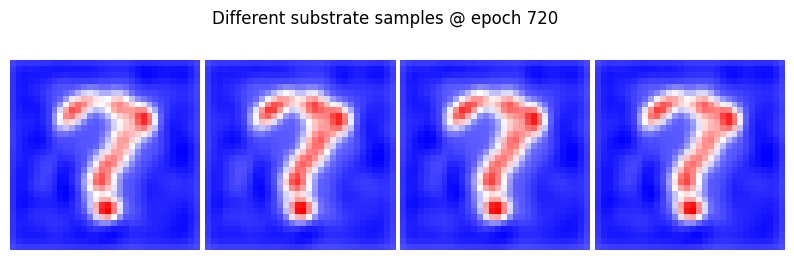

Epoch 721: train=0.1370, val=0.1361
Epoch 722: train=0.1389, val=0.1335
Epoch 723: train=0.1345, val=0.1355
Epoch 724: train=0.1296, val=0.1332
Epoch 725: train=0.1348, val=0.1463
Epoch 726: train=0.1302, val=0.1293
Epoch 727: train=0.1484, val=0.1387
Epoch 728: train=0.1372, val=0.1326
Epoch 729: train=0.1309, val=0.1270
Epoch 730: train=0.1379, val=0.1353
Epoch 731: train=0.1355, val=0.1423
Epoch 732: train=0.1288, val=0.1461
Epoch 733: train=0.1290, val=0.1263
Epoch 734: train=0.1367, val=0.1320
Epoch 735: train=0.1304, val=0.1265
Epoch 736: train=0.1395, val=0.1430
Epoch 737: train=0.1268, val=0.1460
Epoch 738: train=0.1268, val=0.1474
Epoch 739: train=0.1391, val=0.1294
Epoch 740: train=0.1284, val=0.1476
torch.Size([32, 1, 32, 32])


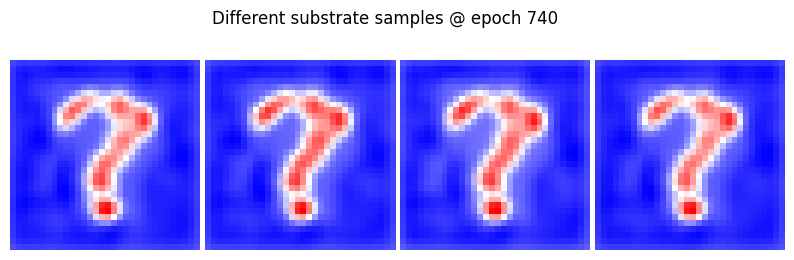

Epoch 741: train=0.1320, val=0.1368
Epoch 742: train=0.1374, val=0.1505
Epoch 743: train=0.1463, val=0.1257
Epoch 744: train=0.1298, val=0.1341
Epoch 745: train=0.1458, val=0.1291
Epoch 746: train=0.1279, val=0.1466
Epoch 747: train=0.1346, val=0.1340
Epoch 748: train=0.1303, val=0.1383
Epoch 749: train=0.1244, val=0.1394
Epoch 750: train=0.1270, val=0.1324
Epoch 751: train=0.1276, val=0.1394
Epoch 752: train=0.1286, val=0.1281
Epoch 753: train=0.1302, val=0.1275
Epoch 754: train=0.1256, val=0.1350
Epoch 755: train=0.1311, val=0.1388
Epoch 756: train=0.1449, val=0.1331
Epoch 757: train=0.1340, val=0.1342
Epoch 758: train=0.1323, val=0.1262
Epoch 759: train=0.1248, val=0.1228
Epoch 760: train=0.1348, val=0.1211
torch.Size([32, 1, 32, 32])


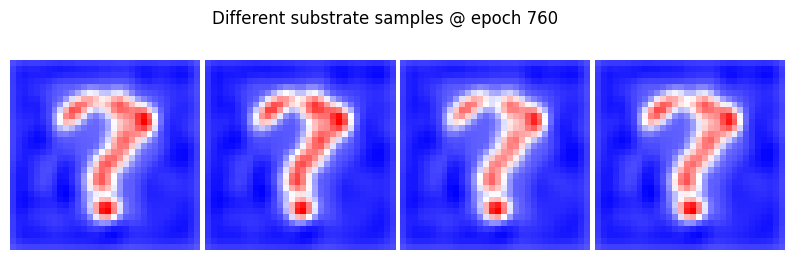

Epoch 761: train=0.1244, val=0.1279
Epoch 762: train=0.1294, val=0.1302
Epoch 763: train=0.1247, val=0.1258
Epoch 764: train=0.1249, val=0.1357
Epoch 765: train=0.1393, val=0.1238
Epoch 766: train=0.1239, val=0.1258
Epoch 767: train=0.1299, val=0.1361
Epoch 768: train=0.1258, val=0.1355
Epoch 769: train=0.1198, val=0.1468
Epoch 770: train=0.1335, val=0.1386
Epoch 771: train=0.1222, val=0.1224
Epoch 772: train=0.1299, val=0.1349
Epoch 773: train=0.1228, val=0.1396
Epoch 774: train=0.1196, val=0.1204
Epoch 775: train=0.1231, val=0.1251
Epoch 776: train=0.1225, val=0.1558
Epoch 777: train=0.1237, val=0.1338
Epoch 778: train=0.1242, val=0.1251
Epoch 779: train=0.1204, val=0.1317
Epoch 780: train=0.1215, val=0.1270
torch.Size([32, 1, 32, 32])


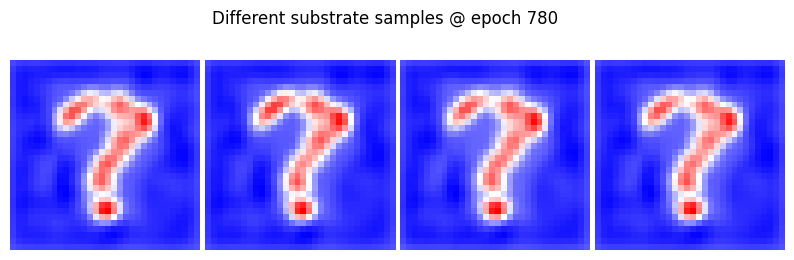

Epoch 781: train=0.1235, val=0.1266
Epoch 782: train=0.1211, val=0.1230
Epoch 783: train=0.1288, val=0.1129
Epoch 784: train=0.1168, val=0.1181
Epoch 785: train=0.1167, val=0.1231
Epoch 786: train=0.1336, val=0.1156
Epoch 787: train=0.1213, val=0.1119
Epoch 788: train=0.1191, val=0.1182
Epoch 789: train=0.1181, val=0.1201
Epoch 790: train=0.1251, val=0.1196
Epoch 791: train=0.1185, val=0.1215
Epoch 792: train=0.1176, val=0.1162
Epoch 793: train=0.1274, val=0.1254
Epoch 794: train=0.1153, val=0.1216
Epoch 795: train=0.1198, val=0.1290
Epoch 796: train=0.1169, val=0.1194
Epoch 797: train=0.1193, val=0.1189
Epoch 798: train=0.1135, val=0.1314
Epoch 799: train=0.1190, val=0.1311
Epoch 800: train=0.1312, val=0.1246
torch.Size([32, 1, 32, 32])


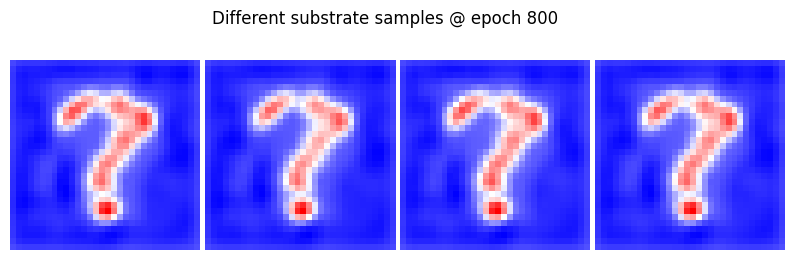

Epoch 801: train=0.1162, val=0.1310
Epoch 802: train=0.1191, val=0.1272
Epoch 803: train=0.1159, val=0.1289
Epoch 804: train=0.1153, val=0.1158
Epoch 805: train=0.1153, val=0.1228
Epoch 806: train=0.1205, val=0.1265
Epoch 807: train=0.1313, val=0.1208
Epoch 808: train=0.1241, val=0.1208
Epoch 809: train=0.1189, val=0.1263
Epoch 810: train=0.1173, val=0.1323
Epoch 811: train=0.1196, val=0.1274
Epoch 812: train=0.1159, val=0.1240
Epoch 813: train=0.1184, val=0.1376
Epoch 814: train=0.1159, val=0.1239
Epoch 815: train=0.1299, val=0.1364
Epoch 816: train=0.1202, val=0.1172
Epoch 817: train=0.1117, val=0.1197
Epoch 818: train=0.1205, val=0.1212
Epoch 819: train=0.1115, val=0.1202
Epoch 820: train=0.1106, val=0.1231
torch.Size([32, 1, 32, 32])


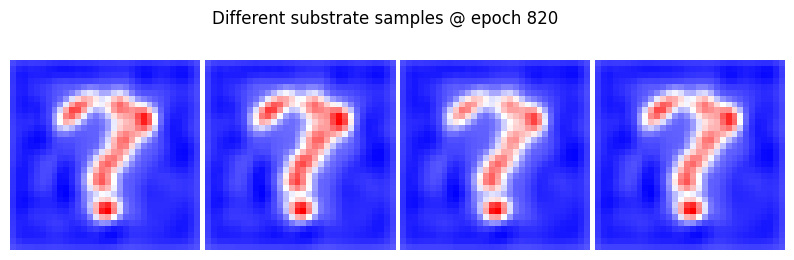

Epoch 821: train=0.1237, val=0.1112
Epoch 822: train=0.1224, val=0.1215
Epoch 823: train=0.1152, val=0.1202
Epoch 824: train=0.1154, val=0.1143
Epoch 825: train=0.1116, val=0.1256
Epoch 826: train=0.1121, val=0.1157
Epoch 827: train=0.1169, val=0.1169
Epoch 828: train=0.1168, val=0.1198
Epoch 829: train=0.1102, val=0.1144
Epoch 830: train=0.1146, val=0.1184
Epoch 831: train=0.1168, val=0.1211
Epoch 832: train=0.1139, val=0.1250
Epoch 833: train=0.1143, val=0.1147
Epoch 834: train=0.1147, val=0.1190
Epoch 835: train=0.1142, val=0.1174
Epoch 836: train=0.1187, val=0.1206
Epoch 837: train=0.1128, val=0.1090
Epoch 838: train=0.1135, val=0.1217
Epoch 839: train=0.1160, val=0.1194
Epoch 840: train=0.1157, val=0.1183
torch.Size([32, 1, 32, 32])


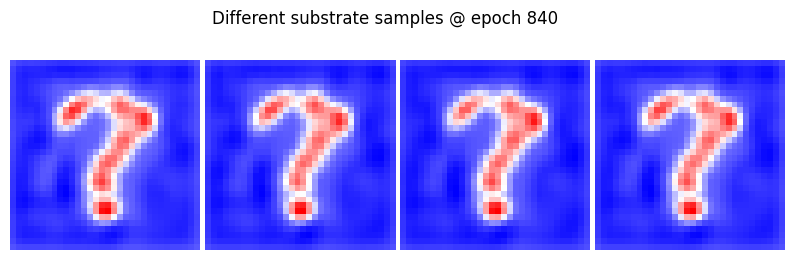

Epoch 841: train=0.1110, val=0.1173
Epoch 842: train=0.1072, val=0.1239
Epoch 843: train=0.1125, val=0.1234
Epoch 844: train=0.1118, val=0.1178
Epoch 845: train=0.1090, val=0.1162
Epoch 846: train=0.1145, val=0.1210
Epoch 847: train=0.1081, val=0.1087
Epoch 848: train=0.1075, val=0.1117
Epoch 849: train=0.1106, val=0.1191
Epoch 850: train=0.1066, val=0.1064
Epoch 851: train=0.1060, val=0.1123
Epoch 852: train=0.1080, val=0.1116
Epoch 853: train=0.1084, val=0.1231
Epoch 854: train=0.1083, val=0.1155
Epoch 855: train=0.1145, val=0.1241
Epoch 856: train=0.1073, val=0.1164
Epoch 857: train=0.1059, val=0.1195
Epoch 858: train=0.1111, val=0.1149
Epoch 859: train=0.1148, val=0.1067
Epoch 860: train=0.1105, val=0.1100
torch.Size([32, 1, 32, 32])


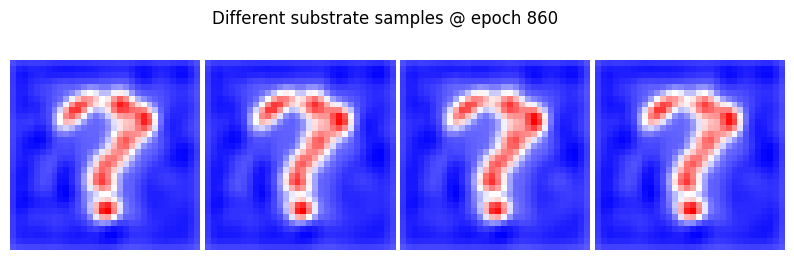

Epoch 861: train=0.1061, val=0.0998
Epoch 862: train=0.1105, val=0.1142
Epoch 863: train=0.1147, val=0.1052
Epoch 864: train=0.1067, val=0.1229
Epoch 865: train=0.1110, val=0.1208
Epoch 866: train=0.1042, val=0.1297
Epoch 867: train=0.1049, val=0.1089
Epoch 868: train=0.1054, val=0.1239
Epoch 869: train=0.1108, val=0.1114
Epoch 870: train=0.1107, val=0.1127
Epoch 871: train=0.1040, val=0.1156
Epoch 872: train=0.1164, val=0.1044
Epoch 873: train=0.1201, val=0.1090
Epoch 874: train=0.1063, val=0.1082
Epoch 875: train=0.1021, val=0.0973
Epoch 876: train=0.1028, val=0.1038
Epoch 877: train=0.1118, val=0.1183
Epoch 878: train=0.1030, val=0.1055
Epoch 879: train=0.1028, val=0.1073
Epoch 880: train=0.1016, val=0.1129
torch.Size([32, 1, 32, 32])


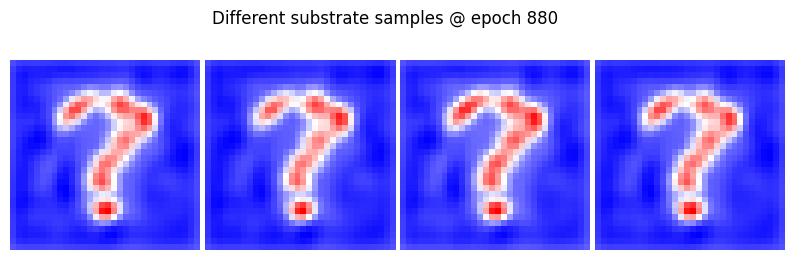

Epoch 881: train=0.1117, val=0.1033
Epoch 882: train=0.1077, val=0.1076
Epoch 883: train=0.1024, val=0.1096
Epoch 884: train=0.1232, val=0.1171
Epoch 885: train=0.1026, val=0.1145
Epoch 886: train=0.1014, val=0.1203
Epoch 887: train=0.1380, val=0.1050
Epoch 888: train=0.1182, val=0.0998
Epoch 889: train=0.1031, val=0.1304
Epoch 890: train=0.0991, val=0.1084
Epoch 891: train=0.1151, val=0.1037
Epoch 892: train=0.1119, val=0.1067
Epoch 893: train=0.1072, val=0.1117
Epoch 894: train=0.1042, val=0.1049
Epoch 895: train=0.1020, val=0.1001
Epoch 896: train=0.1066, val=0.1091
Epoch 897: train=0.1084, val=0.0998
Epoch 898: train=0.1054, val=0.1170
Epoch 899: train=0.1028, val=0.1028
Epoch 900: train=0.1108, val=0.1072
torch.Size([32, 1, 32, 32])


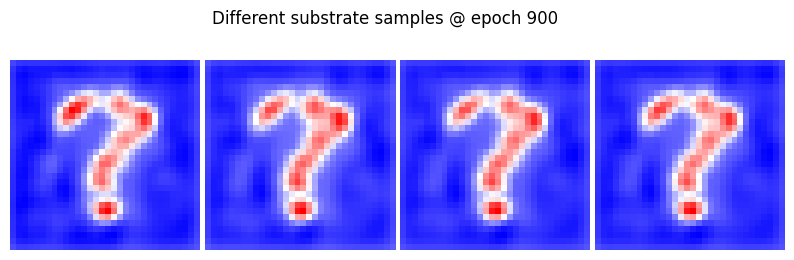

Epoch 901: train=0.1010, val=0.1118
Epoch 902: train=0.1007, val=0.1018
Epoch 903: train=0.1023, val=0.1211
Epoch 904: train=0.1043, val=0.1115
Epoch 905: train=0.1108, val=0.1171
Epoch 906: train=0.0989, val=0.1334
Epoch 907: train=0.1018, val=0.1037
Epoch 908: train=0.0976, val=0.1088
Epoch 909: train=0.0984, val=0.1098
Epoch 910: train=0.1117, val=0.1113
Epoch 911: train=0.1000, val=0.0984
Epoch 912: train=0.1024, val=0.1116
Epoch 913: train=0.1053, val=0.0910
Epoch 914: train=0.1013, val=0.1130
Epoch 915: train=0.0981, val=0.1051
Epoch 916: train=0.1002, val=0.1090
Epoch 917: train=0.0996, val=0.1175
Epoch 918: train=0.0972, val=0.1182
Epoch 919: train=0.1007, val=0.1046
Epoch 920: train=0.1045, val=0.1045
torch.Size([32, 1, 32, 32])


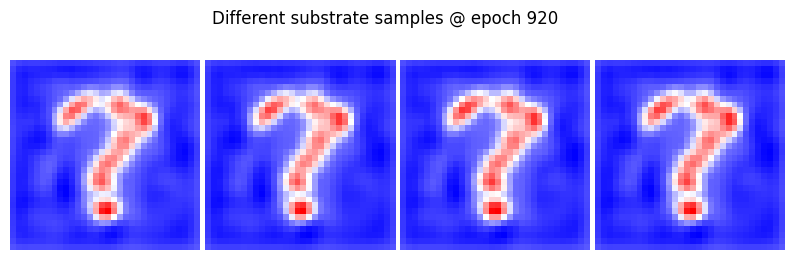

Epoch 921: train=0.0980, val=0.1058
Epoch 922: train=0.1013, val=0.1111
Epoch 923: train=0.1134, val=0.1080
Epoch 924: train=0.1063, val=0.1046
Epoch 925: train=0.1020, val=0.0973
Epoch 926: train=0.0966, val=0.0965
Epoch 927: train=0.0969, val=0.1068
Epoch 928: train=0.0952, val=0.1152
Epoch 929: train=0.1017, val=0.0989
Epoch 930: train=0.0974, val=0.1165
Epoch 931: train=0.1072, val=0.1108
Epoch 932: train=0.0952, val=0.1033
Epoch 933: train=0.0993, val=0.0958
Epoch 934: train=0.0974, val=0.1052
Epoch 935: train=0.0958, val=0.1050
Epoch 936: train=0.1102, val=0.1008
Epoch 937: train=0.0966, val=0.1193
Epoch 938: train=0.0953, val=0.1266
Epoch 939: train=0.1011, val=0.0995
Epoch 940: train=0.0940, val=0.1150
torch.Size([32, 1, 32, 32])


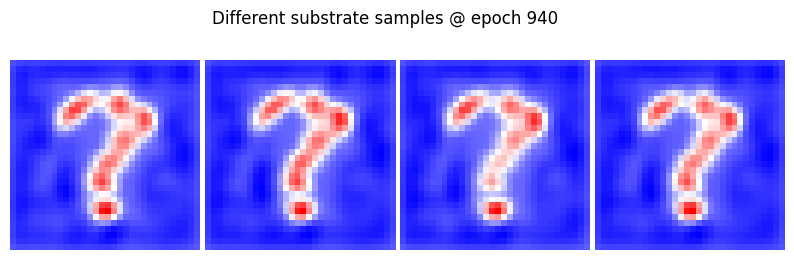

Epoch 941: train=0.0980, val=0.0971
Epoch 942: train=0.0949, val=0.0971
Epoch 943: train=0.0977, val=0.1021
Epoch 944: train=0.0959, val=0.1114
Epoch 945: train=0.0979, val=0.0981
Epoch 946: train=0.1071, val=0.1103
Epoch 947: train=0.0944, val=0.1545
Epoch 948: train=0.1015, val=0.1086
Epoch 949: train=0.0980, val=0.1044
Epoch 950: train=0.1026, val=0.0929
Epoch 951: train=0.0921, val=0.1010
Epoch 952: train=0.0980, val=0.0982
Epoch 953: train=0.0935, val=0.0933
Epoch 954: train=0.0982, val=0.0935
Epoch 955: train=0.0915, val=0.0956
Epoch 956: train=0.0933, val=0.1278
Epoch 957: train=0.0942, val=0.0960
Epoch 958: train=0.0950, val=0.0933
Epoch 959: train=0.1089, val=0.1027
Epoch 960: train=0.0924, val=0.1009
torch.Size([32, 1, 32, 32])


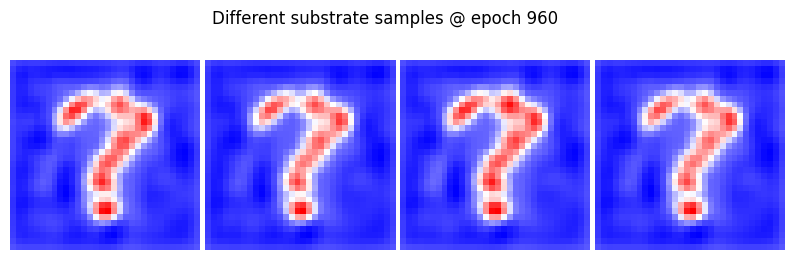

Epoch 961: train=0.0930, val=0.0973
Epoch 962: train=0.0961, val=0.0899
Epoch 963: train=0.0947, val=0.1008
Epoch 964: train=0.0909, val=0.0991
Epoch 965: train=0.1109, val=0.0976
Epoch 966: train=0.0992, val=0.1009
Epoch 967: train=0.0904, val=0.1170
Epoch 968: train=0.1027, val=0.0937
Epoch 969: train=0.0931, val=0.0943
Epoch 970: train=0.0904, val=0.0981
Epoch 971: train=0.0938, val=0.0927
Epoch 972: train=0.0903, val=0.0912
Epoch 973: train=0.0902, val=0.0890
Epoch 974: train=0.0895, val=0.1086
Epoch 975: train=0.0969, val=0.1075
Epoch 976: train=0.1104, val=0.1177
Epoch 977: train=0.0911, val=0.0975
Epoch 978: train=0.0910, val=0.0989
Epoch 979: train=0.0904, val=0.0914
Epoch 980: train=0.0902, val=0.0967
torch.Size([32, 1, 32, 32])


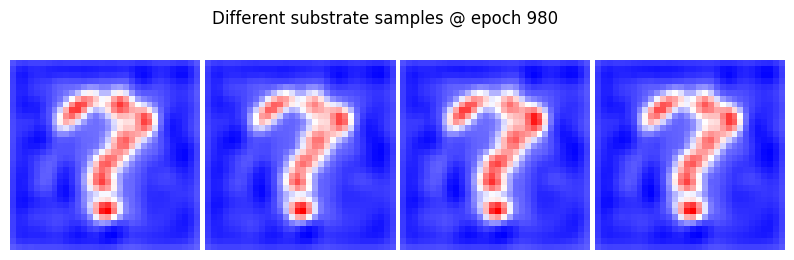

Epoch 981: train=0.1045, val=0.0979
Epoch 982: train=0.0897, val=0.1117
Epoch 983: train=0.0919, val=0.0908
Epoch 984: train=0.0899, val=0.1062
Epoch 985: train=0.1002, val=0.0948
Epoch 986: train=0.0970, val=0.0999
Epoch 987: train=0.0921, val=0.1012
Epoch 988: train=0.0960, val=0.0945
Epoch 989: train=0.0936, val=0.0961
Epoch 990: train=0.0898, val=0.1023
Epoch 991: train=0.0901, val=0.0997
Epoch 992: train=0.0871, val=0.0955
Epoch 993: train=0.0949, val=0.1155
Epoch 994: train=0.0895, val=0.1050
Epoch 995: train=0.0868, val=0.0987
Epoch 996: train=0.0908, val=0.1051
Epoch 997: train=0.1023, val=0.1042
Epoch 998: train=0.0975, val=0.1033
Epoch 999: train=0.0898, val=0.0933
Epoch 1000: train=0.0897, val=0.0900
torch.Size([32, 1, 32, 32])


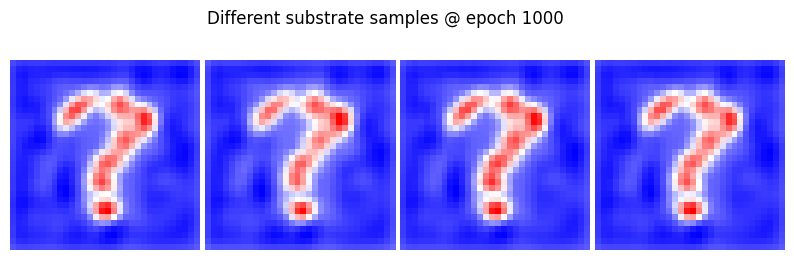

Epoch 1001: train=0.0927, val=0.0979
Epoch 1002: train=0.0894, val=0.0899
Epoch 1003: train=0.0944, val=0.0839
Epoch 1004: train=0.1001, val=0.0954
Epoch 1005: train=0.0909, val=0.0910
Epoch 1006: train=0.0916, val=0.1084
Epoch 1007: train=0.0898, val=0.0980
Epoch 1008: train=0.0870, val=0.1147
Epoch 1009: train=0.0887, val=0.0921
Epoch 1010: train=0.0883, val=0.1096
Epoch 1011: train=0.0868, val=0.1172
Epoch 1012: train=0.0864, val=0.0904
Epoch 1013: train=0.0858, val=0.1010
Epoch 1014: train=0.0886, val=0.1063
Epoch 1015: train=0.0911, val=0.1001
Epoch 1016: train=0.0876, val=0.1002
Epoch 1017: train=0.0924, val=0.1059
Epoch 1018: train=0.1074, val=0.1022
Epoch 1019: train=0.0950, val=0.0951
Epoch 1020: train=0.0854, val=0.0938
torch.Size([32, 1, 32, 32])


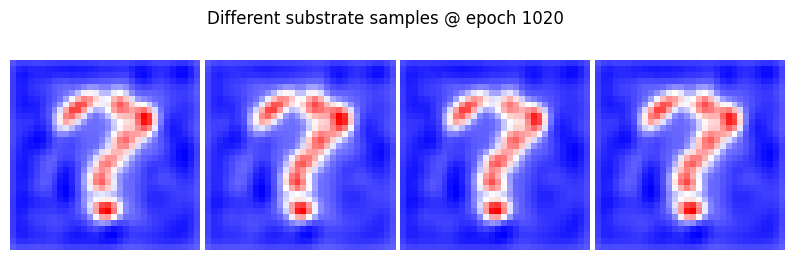

Epoch 1021: train=0.0919, val=0.1044
Epoch 1022: train=0.0856, val=0.0934
Epoch 1023: train=0.0971, val=0.1034
Epoch 1024: train=0.0876, val=0.1016
Epoch 1025: train=0.0947, val=0.0969
Epoch 1026: train=0.0957, val=0.1003
Epoch 1027: train=0.0855, val=0.1029
Epoch 1028: train=0.0861, val=0.1172
Epoch 1029: train=0.0835, val=0.0880
Epoch 1030: train=0.0920, val=0.0952
Epoch 1031: train=0.0979, val=0.0949
Epoch 1032: train=0.1020, val=0.0877
Epoch 1033: train=0.0831, val=0.0893
Epoch 1034: train=0.0855, val=0.0845
Epoch 1035: train=0.0904, val=0.0831
Epoch 1036: train=0.0877, val=0.0836
Epoch 1037: train=0.0900, val=0.1094
Epoch 1038: train=0.0920, val=0.1031
Epoch 1039: train=0.0907, val=0.0968
Epoch 1040: train=0.1008, val=0.0892
torch.Size([32, 1, 32, 32])


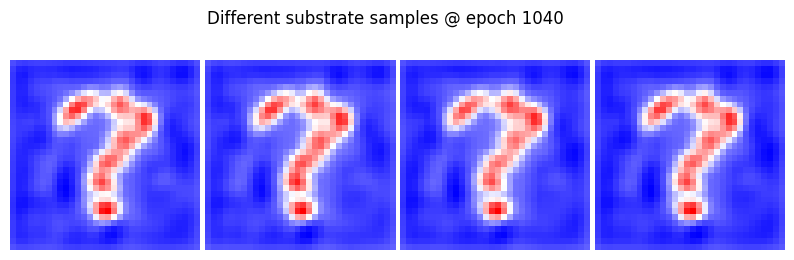

Epoch 1041: train=0.0834, val=0.0886
Epoch 1042: train=0.0907, val=0.0888
Epoch 1043: train=0.0870, val=0.0903
Epoch 1044: train=0.0841, val=0.0991
Epoch 1045: train=0.0886, val=0.0905
Epoch 1046: train=0.0852, val=0.1071
Epoch 1047: train=0.0863, val=0.0885
Epoch 1048: train=0.0860, val=0.0937
Epoch 1049: train=0.0830, val=0.0946
Epoch 1050: train=0.1012, val=0.1040
Epoch 1051: train=0.0846, val=0.0969
Epoch 1052: train=0.0830, val=0.0874
Epoch 1053: train=0.0852, val=0.1014
Epoch 1054: train=0.0871, val=0.0895
Epoch 1055: train=0.0843, val=0.0984
Epoch 1056: train=0.0838, val=0.0900
Epoch 1057: train=0.0863, val=0.0980
Epoch 1058: train=0.0879, val=0.0901
Epoch 1059: train=0.0816, val=0.0942
Epoch 1060: train=0.0900, val=0.1218
torch.Size([32, 1, 32, 32])


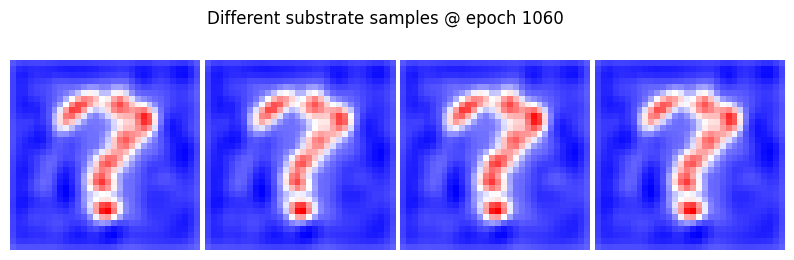

Epoch 1061: train=0.0815, val=0.1101
Epoch 1062: train=0.0847, val=0.0869
Epoch 1063: train=0.0895, val=0.0934
Epoch 1064: train=0.0819, val=0.1251
Epoch 1065: train=0.0934, val=0.0838
Epoch 1066: train=0.0825, val=0.0950
Epoch 1067: train=0.0970, val=0.0999
Epoch 1068: train=0.0885, val=0.0936
Epoch 1069: train=0.1111, val=0.0935
Epoch 1070: train=0.0905, val=0.0853
Epoch 1071: train=0.0880, val=0.0889
Epoch 1072: train=0.0893, val=0.0821
Epoch 1073: train=0.0843, val=0.0885
Epoch 1074: train=0.0938, val=0.0950
Epoch 1075: train=0.0899, val=0.0892
Epoch 1076: train=0.0874, val=0.0932
Epoch 1077: train=0.0853, val=0.0974
Epoch 1078: train=0.0794, val=0.0999
Epoch 1079: train=0.0900, val=0.0995
Epoch 1080: train=0.0801, val=0.1109
torch.Size([32, 1, 32, 32])


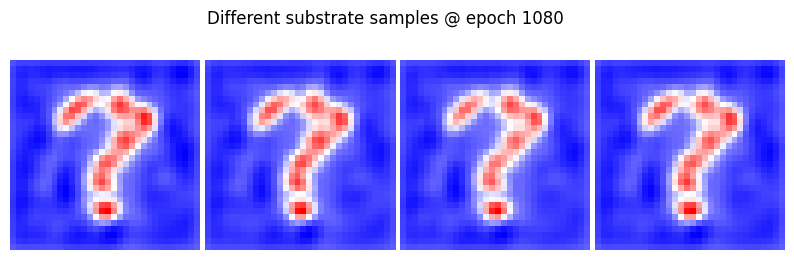

Epoch 1081: train=0.0806, val=0.0889
Epoch 1082: train=0.0821, val=0.0946
Epoch 1083: train=0.0909, val=0.0862
Epoch 1084: train=0.0802, val=0.1046
Epoch 1085: train=0.0799, val=0.1081
Epoch 1086: train=0.0794, val=0.1010
Epoch 1087: train=0.1199, val=0.0914
Epoch 1088: train=0.0856, val=0.0850
Epoch 1089: train=0.0919, val=0.0952
Epoch 1090: train=0.0918, val=0.1023
Epoch 1091: train=0.0780, val=0.0901
Epoch 1092: train=0.0877, val=0.1054
Epoch 1093: train=0.0816, val=0.0911
Epoch 1094: train=0.0833, val=0.0848
Epoch 1095: train=0.0810, val=0.1199
Epoch 1096: train=0.0794, val=0.0887
Epoch 1097: train=0.0819, val=0.0982
Epoch 1098: train=0.0935, val=0.0956
Epoch 1099: train=0.0830, val=0.0865
Epoch 1100: train=0.0811, val=0.0968
torch.Size([32, 1, 32, 32])


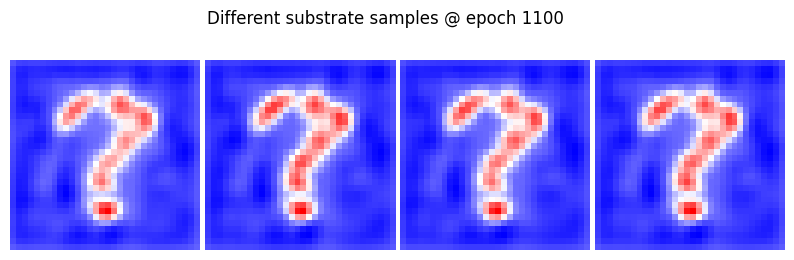

Epoch 1101: train=0.0807, val=0.0959
Epoch 1102: train=0.0795, val=0.0960
Epoch 1103: train=0.0856, val=0.0834
Epoch 1104: train=0.0849, val=0.0878
Epoch 1105: train=0.0777, val=0.0946
Epoch 1106: train=0.0849, val=0.0886
Epoch 1107: train=0.0774, val=0.0978
Epoch 1108: train=0.0852, val=0.0933
Epoch 1109: train=0.0813, val=0.0944
Epoch 1110: train=0.0798, val=0.0990
Epoch 1111: train=0.0800, val=0.1033
Epoch 1112: train=0.0780, val=0.1000
Epoch 1113: train=0.0780, val=0.0948
Epoch 1114: train=0.0884, val=0.0848
Epoch 1115: train=0.0781, val=0.0951
Epoch 1116: train=0.0789, val=0.1136
Epoch 1117: train=0.0776, val=0.0923
Epoch 1118: train=0.1031, val=0.0828
Epoch 1119: train=0.0816, val=0.0860
Epoch 1120: train=0.0822, val=0.0914
torch.Size([32, 1, 32, 32])


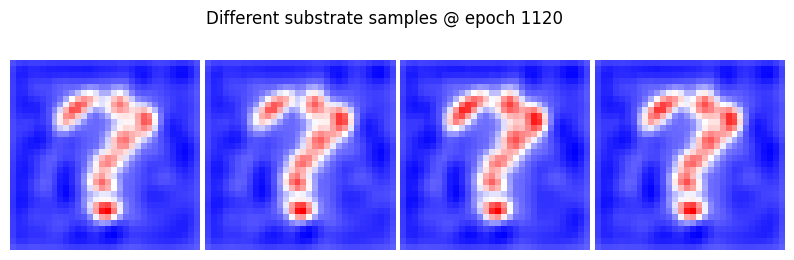

Epoch 1121: train=0.0775, val=0.0875
Epoch 1122: train=0.0793, val=0.0813
Epoch 1123: train=0.0826, val=0.0847
Epoch 1124: train=0.0770, val=0.0862
Epoch 1125: train=0.0867, val=0.0911
Epoch 1126: train=0.0796, val=0.0883
Epoch 1127: train=0.0796, val=0.0916
Epoch 1128: train=0.0780, val=0.0837
Epoch 1129: train=0.0888, val=0.0899
Epoch 1130: train=0.0795, val=0.0850
Epoch 1131: train=0.0754, val=0.0941
Epoch 1132: train=0.0785, val=0.0973
Epoch 1133: train=0.0770, val=0.0891
Epoch 1134: train=0.0755, val=0.0815
Epoch 1135: train=0.0759, val=0.0986
Epoch 1136: train=0.0779, val=0.0930
Epoch 1137: train=0.0779, val=0.0911
Epoch 1138: train=0.0823, val=0.0944
Epoch 1139: train=0.0772, val=0.0919
Epoch 1140: train=0.0768, val=0.0915
torch.Size([32, 1, 32, 32])


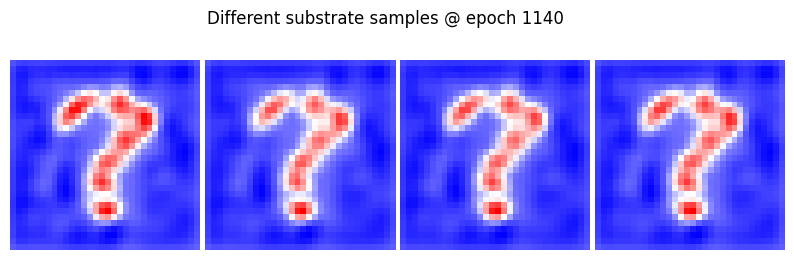

Epoch 1141: train=0.0767, val=0.1036
Epoch 1142: train=0.0763, val=0.1141
Epoch 1143: train=0.0914, val=0.0832
Epoch 1144: train=0.0872, val=0.0984
Epoch 1145: train=0.0783, val=0.0950
Epoch 1146: train=0.0781, val=0.0856
Epoch 1147: train=0.0755, val=0.0854
Epoch 1148: train=0.0855, val=0.0894
Epoch 1149: train=0.0791, val=0.0839
Epoch 1150: train=0.0833, val=0.0825
Epoch 1151: train=0.0773, val=0.1265
Epoch 1152: train=0.0865, val=0.0948
Epoch 1153: train=0.0754, val=0.0945
Epoch 1154: train=0.0832, val=0.1120
Epoch 1155: train=0.0752, val=0.0925
Epoch 1156: train=0.0782, val=0.0844
Epoch 1157: train=0.0820, val=0.1030
Epoch 1158: train=0.0813, val=0.1140
Epoch 1159: train=0.0845, val=0.0976
Epoch 1160: train=0.0804, val=0.1065
torch.Size([32, 1, 32, 32])


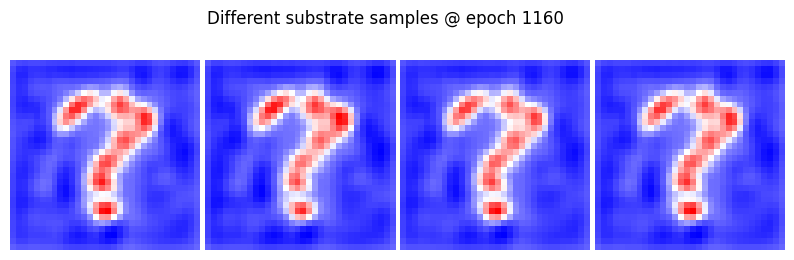

Epoch 1161: train=0.0762, val=0.1410
Epoch 1162: train=0.0774, val=0.1101
Epoch 1163: train=0.0775, val=0.0836
Epoch 1164: train=0.0774, val=0.0904
Epoch 1165: train=0.0854, val=0.1187
Epoch 1166: train=0.0823, val=0.1099
Epoch 1167: train=0.0763, val=0.0879
Epoch 1168: train=0.0804, val=0.0928
Epoch 1169: train=0.0751, val=0.1019
Epoch 1170: train=0.0743, val=0.0897
Epoch 1171: train=0.0876, val=0.0877
Epoch 1172: train=0.0812, val=0.0861
Epoch 1173: train=0.0785, val=0.1101
Epoch 1174: train=0.0981, val=0.0974
Epoch 1175: train=0.0760, val=0.0896
Epoch 1176: train=0.0746, val=0.0815
Epoch 1177: train=0.0735, val=0.0857
Epoch 1178: train=0.0745, val=0.0926
Epoch 1179: train=0.0744, val=0.0942
Epoch 1180: train=0.0777, val=0.0950
torch.Size([32, 1, 32, 32])


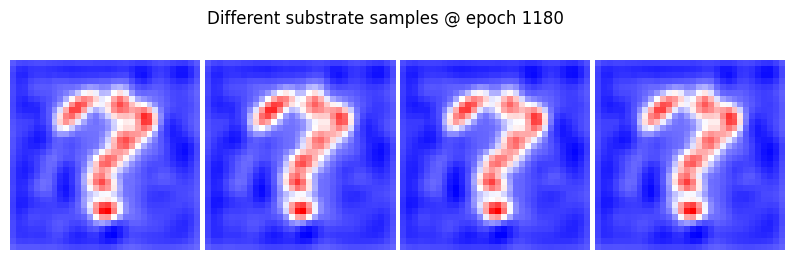

Epoch 1181: train=0.0736, val=0.0880
Epoch 1182: train=0.0772, val=0.0981
Epoch 1183: train=0.0757, val=0.0897
Epoch 1184: train=0.0811, val=0.0863
Epoch 1185: train=0.0773, val=0.1111
Epoch 1186: train=0.0727, val=0.0899
Epoch 1187: train=0.0788, val=0.0864
Epoch 1188: train=0.0740, val=0.0932
Epoch 1189: train=0.0787, val=0.0818
Epoch 1190: train=0.0774, val=0.0787
Epoch 1191: train=0.0723, val=0.0997
Epoch 1192: train=0.0750, val=0.0881
Epoch 1193: train=0.0738, val=0.0918
Epoch 1194: train=0.0762, val=0.0938
Epoch 1195: train=0.0736, val=0.0877
Epoch 1196: train=0.0728, val=0.0767
Epoch 1197: train=0.0738, val=0.1107
Epoch 1198: train=0.0739, val=0.1032
Epoch 1199: train=0.0756, val=0.0877
Epoch 1200: train=0.0735, val=0.0867
torch.Size([32, 1, 32, 32])


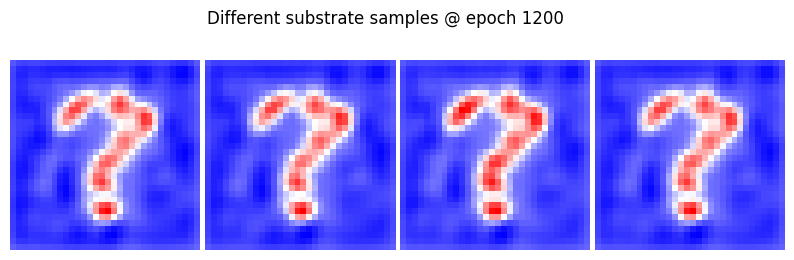

Epoch 1201: train=0.0726, val=0.1026
Epoch 1202: train=0.0731, val=0.0870
Epoch 1203: train=0.0764, val=0.0841
Epoch 1204: train=0.0826, val=0.0898
Epoch 1205: train=0.0707, val=0.0846
Epoch 1206: train=0.0716, val=0.0823
Epoch 1207: train=0.0743, val=0.0852
Epoch 1208: train=0.0732, val=0.1059
Epoch 1209: train=0.0718, val=0.0832
Epoch 1210: train=0.0713, val=0.0859
Epoch 1211: train=0.0728, val=0.0857
Epoch 1212: train=0.0713, val=0.0802
Epoch 1213: train=0.0711, val=0.0867
Epoch 1214: train=0.0718, val=0.1080
Epoch 1215: train=0.0746, val=0.0810
Epoch 1216: train=0.0727, val=0.1092
Epoch 1217: train=0.0733, val=0.0809
Epoch 1218: train=0.0767, val=0.0824
Epoch 1219: train=0.0698, val=0.0940
Epoch 1220: train=0.0730, val=0.0997
torch.Size([32, 1, 32, 32])


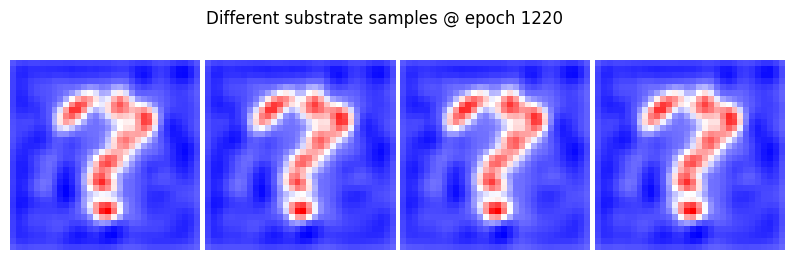

Epoch 1221: train=0.0719, val=0.0891
Epoch 1222: train=0.0722, val=0.0972
Epoch 1223: train=0.0733, val=0.1073
Epoch 1224: train=0.0723, val=0.0901
Epoch 1225: train=0.0750, val=0.0842
Epoch 1226: train=0.0750, val=0.0824
Epoch 1227: train=0.0768, val=0.0915
Epoch 1228: train=0.0719, val=0.0819
Epoch 1229: train=0.0730, val=0.0879
Epoch 1230: train=0.0715, val=0.0834
Epoch 1231: train=0.0793, val=0.0783
Epoch 1232: train=0.0716, val=0.1010
Epoch 1233: train=0.0788, val=0.0816
Epoch 1234: train=0.0744, val=0.0870
Epoch 1235: train=0.0815, val=0.0971
Epoch 1236: train=0.0704, val=0.0933
Epoch 1237: train=0.0732, val=0.0941
Epoch 1238: train=0.0772, val=0.0842
Epoch 1239: train=0.0699, val=0.0820
Epoch 1240: train=0.0878, val=0.0825
torch.Size([32, 1, 32, 32])


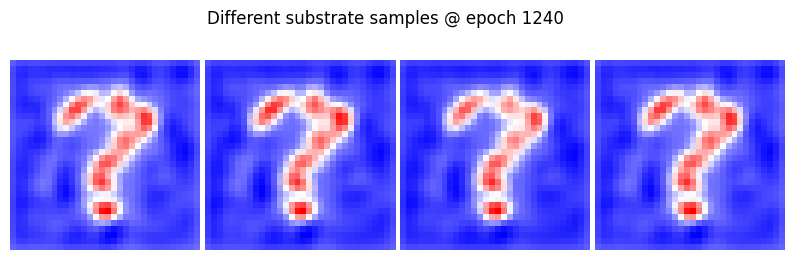

Epoch 1241: train=0.0822, val=0.0882
Epoch 1242: train=0.0866, val=0.1130
Epoch 1243: train=0.0774, val=0.0931
Epoch 1244: train=0.0753, val=0.0944
Epoch 1245: train=0.0744, val=0.0968
Epoch 1246: train=0.0701, val=0.0775
Epoch 1247: train=0.0727, val=0.0902
Epoch 1248: train=0.0744, val=0.1161
Epoch 1249: train=0.0742, val=0.0862
Epoch 1250: train=0.0698, val=0.0856
Epoch 1251: train=0.0876, val=0.0818
Epoch 1252: train=0.0732, val=0.0868
Epoch 1253: train=0.0700, val=0.0794
Epoch 1254: train=0.0776, val=0.0958
Epoch 1255: train=0.0710, val=0.0919
Epoch 1256: train=0.0687, val=0.0856
Epoch 1257: train=0.0779, val=0.0843
Epoch 1258: train=0.0796, val=0.0858
Epoch 1259: train=0.0745, val=0.0886
Epoch 1260: train=0.0674, val=0.0896
torch.Size([32, 1, 32, 32])


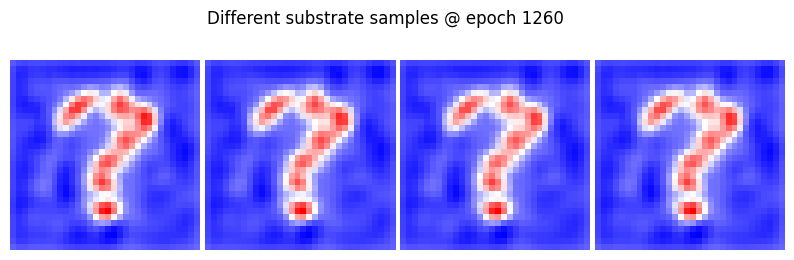

Epoch 1261: train=0.0724, val=0.0797
Epoch 1262: train=0.0707, val=0.0870
Epoch 1263: train=0.0779, val=0.0971
Epoch 1264: train=0.0903, val=0.0939
Epoch 1265: train=0.0809, val=0.0968
Epoch 1266: train=0.0710, val=0.1057
Epoch 1267: train=0.0722, val=0.0906
Epoch 1268: train=0.0740, val=0.0841
Epoch 1269: train=0.0793, val=0.0891
Epoch 1270: train=0.0734, val=0.0850
Epoch 1271: train=0.0826, val=0.0947
Epoch 1272: train=0.0686, val=0.0874
Epoch 1273: train=0.0676, val=0.0864
Epoch 1274: train=0.0708, val=0.0868
Epoch 1275: train=0.0765, val=0.0920
Epoch 1276: train=0.0682, val=0.0998
Epoch 1277: train=0.0713, val=0.0846
Epoch 1278: train=0.0718, val=0.0824
Epoch 1279: train=0.0711, val=0.0865
Epoch 1280: train=0.0686, val=0.0901
torch.Size([32, 1, 32, 32])


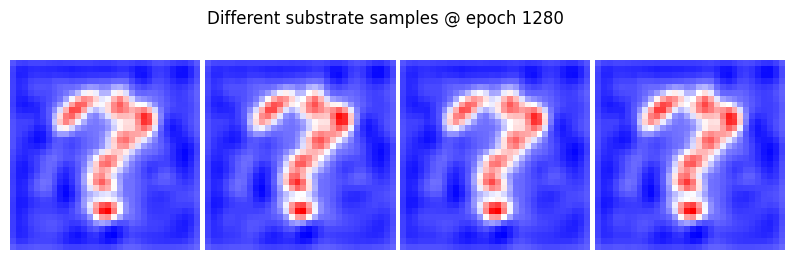

Epoch 1281: train=0.0691, val=0.0839
Epoch 1282: train=0.0685, val=0.1102
Epoch 1283: train=0.0694, val=0.0865
Epoch 1284: train=0.0671, val=0.0966
Epoch 1285: train=0.0662, val=0.0783
Epoch 1286: train=0.0668, val=0.0869
Epoch 1287: train=0.0745, val=0.0899
Epoch 1288: train=0.0692, val=0.0829
Epoch 1289: train=0.0717, val=0.0918
Epoch 1290: train=0.0665, val=0.0911
Epoch 1291: train=0.0706, val=0.0971
Epoch 1292: train=0.0672, val=0.1035
Epoch 1293: train=0.0716, val=0.0821
Epoch 1294: train=0.0783, val=0.0922
Epoch 1295: train=0.0676, val=0.0839
Epoch 1296: train=0.0667, val=0.0856
Epoch 1297: train=0.0703, val=0.0987
Epoch 1298: train=0.0747, val=0.0857
Epoch 1299: train=0.0741, val=0.0898
Epoch 1300: train=0.0660, val=0.0835
torch.Size([32, 1, 32, 32])


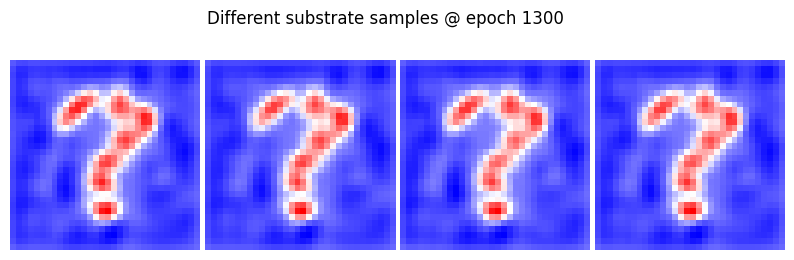

Epoch 1301: train=0.0684, val=0.0893
Epoch 1302: train=0.0686, val=0.0865
Epoch 1303: train=0.0686, val=0.0868
Epoch 1304: train=0.0807, val=0.0936
Epoch 1305: train=0.0655, val=0.0849
Epoch 1306: train=0.0681, val=0.1002
Epoch 1307: train=0.0667, val=0.0872
Epoch 1308: train=0.0663, val=0.0866
Epoch 1309: train=0.0665, val=0.1030
Epoch 1310: train=0.0670, val=0.0951
Epoch 1311: train=0.0712, val=0.1159
Epoch 1312: train=0.0664, val=0.0876
Epoch 1313: train=0.0666, val=0.0827
Epoch 1314: train=0.0913, val=0.0817
Epoch 1315: train=0.0745, val=0.0780
Epoch 1316: train=0.0720, val=0.0909
Epoch 1317: train=0.0716, val=0.1061
Epoch 1318: train=0.0664, val=0.0839
Epoch 1319: train=0.0674, val=0.0936
Epoch 1320: train=0.0781, val=0.0907
torch.Size([32, 1, 32, 32])


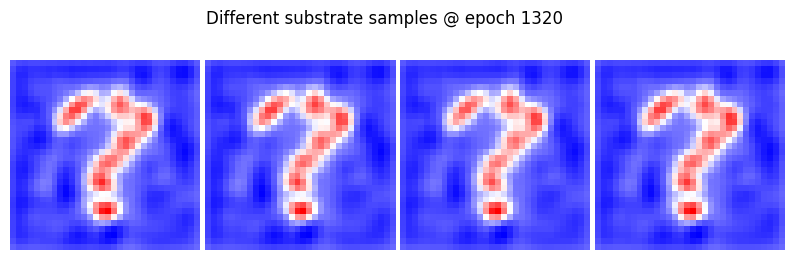

Epoch 1321: train=0.0666, val=0.0897
Epoch 1322: train=0.0682, val=0.0984
Epoch 1323: train=0.0658, val=0.0841
Epoch 1324: train=0.0770, val=0.0780
Epoch 1325: train=0.0731, val=0.1002
Epoch 1326: train=0.0660, val=0.1097
Epoch 1327: train=0.0682, val=0.0956
Epoch 1328: train=0.0723, val=0.0849
Epoch 1329: train=0.0665, val=0.0829
Epoch 1330: train=0.0788, val=0.0855
Epoch 1331: train=0.0718, val=0.0952
Epoch 1332: train=0.0650, val=0.0992
Epoch 1333: train=0.0686, val=0.0889
Epoch 1334: train=0.0647, val=0.0951
Epoch 1335: train=0.0683, val=0.0878
Epoch 1336: train=0.0684, val=0.1176
Epoch 1337: train=0.0743, val=0.1083
Epoch 1338: train=0.0652, val=0.0921
Epoch 1339: train=0.0657, val=0.0880
Epoch 1340: train=0.0684, val=0.1084
torch.Size([32, 1, 32, 32])


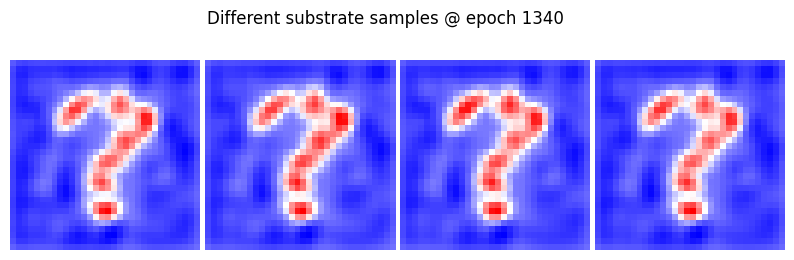

Epoch 1341: train=0.0637, val=0.0958
Epoch 1342: train=0.0663, val=0.0999
Epoch 1343: train=0.0648, val=0.0760
Epoch 1344: train=0.0643, val=0.0889
Epoch 1345: train=0.0654, val=0.0887
Epoch 1346: train=0.0652, val=0.0895
Epoch 1347: train=0.0690, val=0.0887
Epoch 1348: train=0.0650, val=0.0925
Epoch 1349: train=0.0643, val=0.0879
Epoch 1350: train=0.0641, val=0.0940
Epoch 1351: train=0.0649, val=0.0945
Epoch 1352: train=0.0661, val=0.0919
Epoch 1353: train=0.0639, val=0.0846
Epoch 1354: train=0.0662, val=0.0881
Epoch 1355: train=0.0655, val=0.0853
Epoch 1356: train=0.0637, val=0.0869
Epoch 1357: train=0.0740, val=0.0821
Epoch 1358: train=0.0639, val=0.0977
Epoch 1359: train=0.0698, val=0.0848
Epoch 1360: train=0.0644, val=0.0864
torch.Size([32, 1, 32, 32])


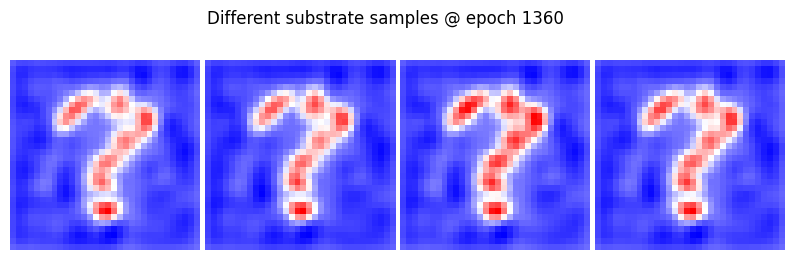

Epoch 1361: train=0.0740, val=0.0850
Epoch 1362: train=0.0654, val=0.1110
Epoch 1363: train=0.0643, val=0.0876
Epoch 1364: train=0.0655, val=0.1026
Epoch 1365: train=0.0825, val=0.0890
Epoch 1366: train=0.0825, val=0.0839
Epoch 1367: train=0.0619, val=0.0825
Epoch 1368: train=0.0645, val=0.0903
Epoch 1369: train=0.0655, val=0.0785
Epoch 1370: train=0.0658, val=0.0794
Epoch 1371: train=0.0711, val=0.0947
Epoch 1372: train=0.0649, val=0.0762
Epoch 1373: train=0.0658, val=0.0922
Epoch 1374: train=0.0632, val=0.1143
Epoch 1375: train=0.0642, val=0.0865
Epoch 1376: train=0.0670, val=0.0786
Epoch 1377: train=0.0639, val=0.0919
Epoch 1378: train=0.0718, val=0.0876
Epoch 1379: train=0.0631, val=0.0855
Epoch 1380: train=0.0661, val=0.0835
torch.Size([32, 1, 32, 32])


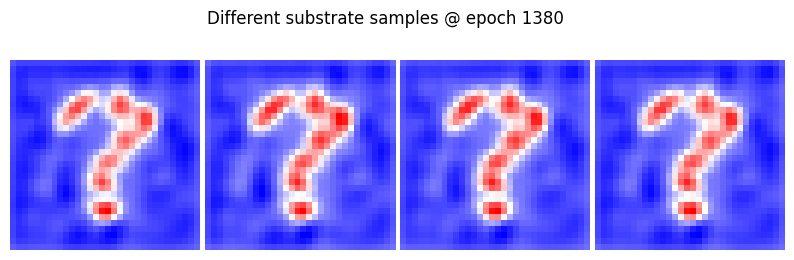

Epoch 1381: train=0.0690, val=0.0871
Epoch 1382: train=0.0651, val=0.0814
Epoch 1383: train=0.0641, val=0.0855
Epoch 1384: train=0.0772, val=0.0884
Epoch 1385: train=0.0742, val=0.0876
Epoch 1386: train=0.0807, val=0.0814
Epoch 1387: train=0.0718, val=0.0908
Epoch 1388: train=0.0632, val=0.0852
Epoch 1389: train=0.0678, val=0.0868
Epoch 1390: train=0.0801, val=0.0903
Epoch 1391: train=0.0700, val=0.0824
Epoch 1392: train=0.0679, val=0.1081
Epoch 1393: train=0.0646, val=0.0818
Epoch 1394: train=0.0647, val=0.1211
Epoch 1395: train=0.0631, val=0.0823
Epoch 1396: train=0.0749, val=0.0944
Epoch 1397: train=0.0638, val=0.0847
Epoch 1398: train=0.0729, val=0.0794
Epoch 1399: train=0.0640, val=0.0815
Epoch 1400: train=0.0626, val=0.1074
torch.Size([32, 1, 32, 32])


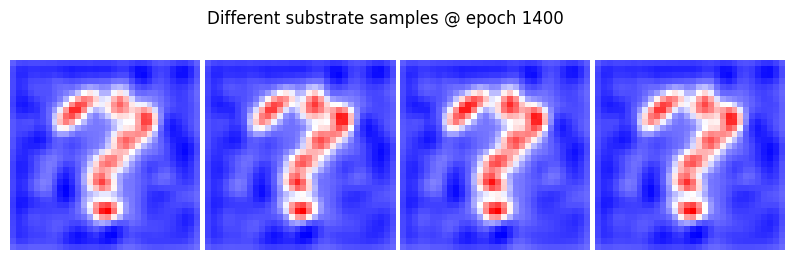

Epoch 1401: train=0.0649, val=0.0967
Epoch 1402: train=0.0635, val=0.0887
Epoch 1403: train=0.0632, val=0.0935
Epoch 1404: train=0.0607, val=0.0860
Epoch 1405: train=0.0684, val=0.0870
Epoch 1406: train=0.0652, val=0.1217
Epoch 1407: train=0.0690, val=0.0787
Epoch 1408: train=0.0674, val=0.0872
Epoch 1409: train=0.0657, val=0.0844
Epoch 1410: train=0.0616, val=0.0855
Epoch 1411: train=0.0630, val=0.0848
Epoch 1412: train=0.0648, val=0.0878
Epoch 1413: train=0.0606, val=0.0730
Epoch 1414: train=0.0624, val=0.0833
Epoch 1415: train=0.0622, val=0.0918
Epoch 1416: train=0.0623, val=0.0877
Epoch 1417: train=0.0620, val=0.0949
Epoch 1418: train=0.0686, val=0.1750
Epoch 1419: train=0.0652, val=0.0890
Epoch 1420: train=0.0642, val=0.0986
torch.Size([32, 1, 32, 32])


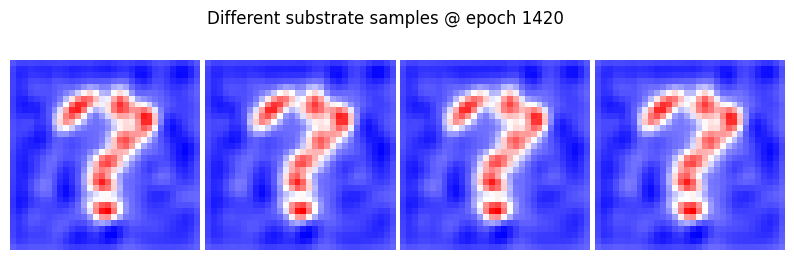

Epoch 1421: train=0.0647, val=0.0827
Epoch 1422: train=0.0622, val=0.0936
Epoch 1423: train=0.0630, val=0.0839
Epoch 1424: train=0.0654, val=0.0894
Epoch 1425: train=0.0621, val=0.0750
Epoch 1426: train=0.0700, val=0.1190
Epoch 1427: train=0.0743, val=0.0832
Epoch 1428: train=0.0617, val=0.0788
Epoch 1429: train=0.0644, val=0.0890
Epoch 1430: train=0.0627, val=0.0931
Epoch 1431: train=0.0664, val=0.0966
Epoch 1432: train=0.0652, val=0.1017
Epoch 1433: train=0.0619, val=0.0983
Epoch 1434: train=0.0608, val=0.0769
Epoch 1435: train=0.0754, val=0.0893
Epoch 1436: train=0.0684, val=0.0848
Epoch 1437: train=0.0639, val=0.0850
Epoch 1438: train=0.0612, val=0.0874
Epoch 1439: train=0.0690, val=0.0814
Epoch 1440: train=0.0628, val=0.1051
torch.Size([32, 1, 32, 32])


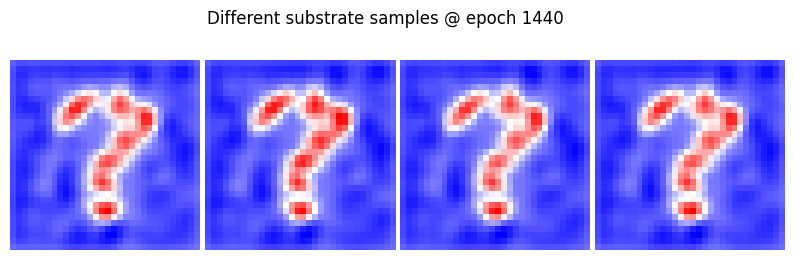

Epoch 1441: train=0.0706, val=0.0833
Epoch 1442: train=0.0613, val=0.0883
Epoch 1443: train=0.0665, val=0.0859
Epoch 1444: train=0.0603, val=0.0848
Epoch 1445: train=0.0592, val=0.0776
Epoch 1446: train=0.0625, val=0.0760
Epoch 1447: train=0.0640, val=0.0917
Epoch 1448: train=0.0648, val=0.0823
Epoch 1449: train=0.0633, val=0.0796
Epoch 1450: train=0.0676, val=0.1025
Epoch 1451: train=0.0596, val=0.0742
Epoch 1452: train=0.0619, val=0.0764
Epoch 1453: train=0.0648, val=0.0749
Epoch 1454: train=0.0663, val=0.0916
Epoch 1455: train=0.0623, val=0.0790
Epoch 1456: train=0.0615, val=0.0904
Epoch 1457: train=0.0628, val=0.0865
Epoch 1458: train=0.0765, val=0.0812
Epoch 1459: train=0.0642, val=0.0750
Epoch 1460: train=0.0670, val=0.0848
torch.Size([32, 1, 32, 32])


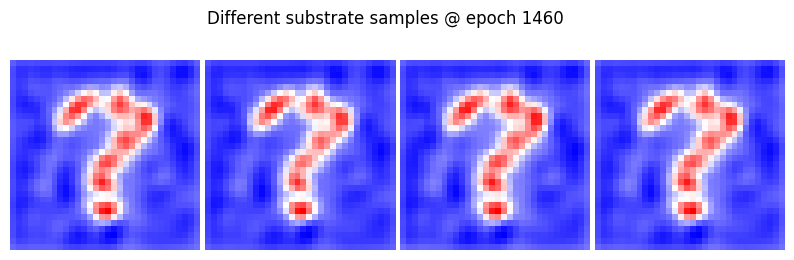

Epoch 1461: train=0.0607, val=0.0902
Epoch 1462: train=0.0601, val=0.1098
Epoch 1463: train=0.0640, val=0.0826
Epoch 1464: train=0.0671, val=0.0797
Epoch 1465: train=0.0607, val=0.0810
Epoch 1466: train=0.0612, val=0.0782
Epoch 1467: train=0.0605, val=0.0747
Epoch 1468: train=0.0600, val=0.0861
Epoch 1469: train=0.0598, val=0.0816
Epoch 1470: train=0.0592, val=0.0973
Epoch 1471: train=0.0609, val=0.0943
Epoch 1472: train=0.0624, val=0.0825
Epoch 1473: train=0.0600, val=0.0990
Epoch 1474: train=0.0605, val=0.0797
Epoch 1475: train=0.0615, val=0.0919
Epoch 1476: train=0.0715, val=0.0796
Epoch 1477: train=0.0594, val=0.1259
Epoch 1478: train=0.0664, val=0.0701
Epoch 1479: train=0.0591, val=0.0867
Epoch 1480: train=0.0593, val=0.0897
torch.Size([32, 1, 32, 32])


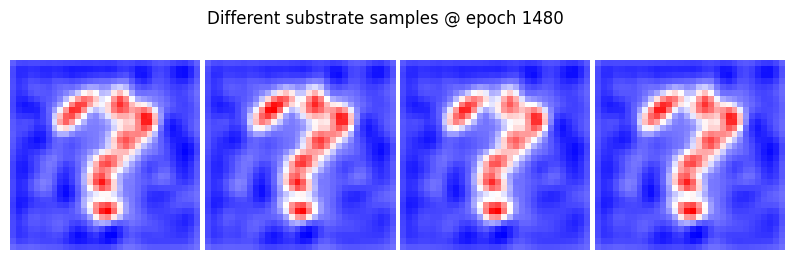

Epoch 1481: train=0.0639, val=0.0793
Epoch 1482: train=0.0594, val=0.1031
Epoch 1483: train=0.0609, val=0.0796
Epoch 1484: train=0.0599, val=0.0867
Epoch 1485: train=0.0622, val=0.1075
Epoch 1486: train=0.0627, val=0.0875
Epoch 1487: train=0.0579, val=0.1099
Epoch 1488: train=0.0628, val=0.1005
Epoch 1489: train=0.0618, val=0.0863
Epoch 1490: train=0.0612, val=0.0807
Epoch 1491: train=0.0596, val=0.0870
Epoch 1492: train=0.0663, val=0.0934
Epoch 1493: train=0.0590, val=0.0867
Epoch 1494: train=0.0641, val=0.0831
Epoch 1495: train=0.0601, val=0.0784
Epoch 1496: train=0.0597, val=0.0861
Epoch 1497: train=0.0580, val=0.0946
Epoch 1498: train=0.0624, val=0.0838
Epoch 1499: train=0.0599, val=0.0768
Epoch 1500: train=0.0602, val=0.0800
torch.Size([32, 1, 32, 32])


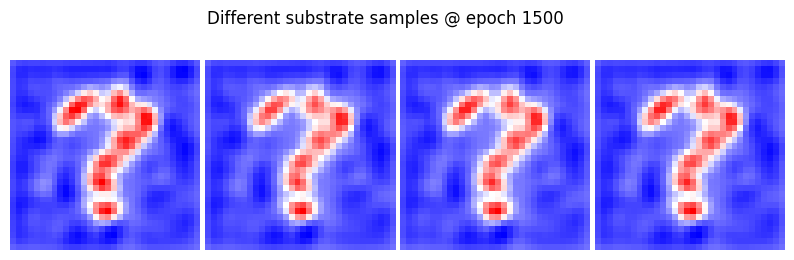

Epoch 1501: train=0.0706, val=0.0809
Epoch 1502: train=0.0646, val=0.0956
Epoch 1503: train=0.0599, val=0.0816
Epoch 1504: train=0.0587, val=0.0960
Epoch 1505: train=0.0588, val=0.0786
Epoch 1506: train=0.0636, val=0.0805
Epoch 1507: train=0.0648, val=0.0988
Epoch 1508: train=0.0616, val=0.0761
Epoch 1509: train=0.0621, val=0.0998
Epoch 1510: train=0.0584, val=0.0891
Epoch 1511: train=0.0657, val=0.0818
Epoch 1512: train=0.0580, val=0.0818
Epoch 1513: train=0.0579, val=0.0669
Epoch 1514: train=0.0603, val=0.1226
Epoch 1515: train=0.0598, val=0.0800
Epoch 1516: train=0.0604, val=0.1028
Epoch 1517: train=0.0596, val=0.0748
Epoch 1518: train=0.0640, val=0.0876
Epoch 1519: train=0.0672, val=0.0764
Epoch 1520: train=0.0587, val=0.1180
torch.Size([32, 1, 32, 32])


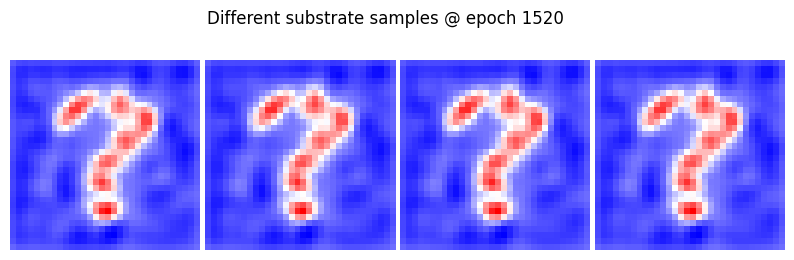

Epoch 1521: train=0.0597, val=0.0839
Epoch 1522: train=0.0623, val=0.0802
Epoch 1523: train=0.0629, val=0.0780
Epoch 1524: train=0.0596, val=0.0764
Epoch 1525: train=0.0588, val=0.0822
Epoch 1526: train=0.0577, val=0.0836
Epoch 1527: train=0.0578, val=0.0967
Epoch 1528: train=0.0644, val=0.1164
Epoch 1529: train=0.0628, val=0.0939
Epoch 1530: train=0.0640, val=0.0793
Epoch 1531: train=0.0678, val=0.0949
Epoch 1532: train=0.0592, val=0.0837
Epoch 1533: train=0.0587, val=0.0892
Epoch 1534: train=0.0725, val=0.1038


KeyboardInterrupt: 

In [48]:
EPOCHS = 3000
best_loss = float('inf')
best_epoch = 0

training_losses = []
validation_losses = []

for epoch in range(EPOCHS):
    # -------------------------
    # TRAINING
    # -------------------------
    model.train()
    train_loss_epoch = 0
    ctr = 0

    for x, y in train_loader:
        optimizer.zero_grad()

        # x, y already on GPU by your dataset wrapper
        ret = model(x, y)
        loss = ret['loss']

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss_epoch += loss.item()
        ctr += 1

    training_losses.append(train_loss_epoch / ctr)

    # -------------------------
    # VALIDATION
    # -------------------------
    model.eval()
    val_losses = []
    with torch.no_grad():
        for x, y in val_loader:
            ret = model(x, y)
            val_losses.append(ret['loss'].item())

    val_loss = np.mean(val_losses)
    validation_losses.append(val_loss)
    scheduler.step()

    # -------------------------
    # LOGGING (every epoch)
    # -------------------------
    if epoch % 1 == 0:
        print(f"Epoch {epoch}: train={training_losses[-1]:.4f}, val={val_loss:.4f}")

    # -------------------------
    # SAVE BEST MODEL
    # -------------------------
    if val_loss < best_loss:
        best_loss = val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), "diffusion_substrate_best.pth")
        # Also save EMA model
        # torch.save(ema_model.state_dict(), "diffusion_substrate_best_ema.pth")

    # -------------------------
    # VISUALIZATION (every 20 epochs, matching your style)
    # -------------------------
    if epoch % 20 == 0:
        model.eval()
        with torch.no_grad():
            # Use EMA model for better quality samples
            samples = sample_substrates(model, n_samples=32)
            print(samples.shape)
            samples = samples[:, 0, :, :].cpu().numpy()  # [4, H, W]

        # Create visualization matching your style exactly
        fig = plt.figure(figsize=(10, 3))
        grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.05)
        
        # Show first 3 individual samples
        for i in range(3):
            grid[i].imshow(samples[i], cmap='bwr')
            grid[i].axis('off')
        
        # Show mean of all samples in the 4th panel
        grid[i+1].imshow(np.mean(samples, axis=0), cmap='bwr')
        grid[i+1].axis('off')
        
        plt.suptitle(f"Different substrate samples @ epoch {epoch}")
        plt.show()
        
        model.train()

print(f"\nTraining done. Best epoch={best_epoch}, best val loss={best_loss:.4f}")


In [57]:
model = torch.load("discrete_diffusion.pth")

In [61]:
print(avg1.shape)

(32, 32)


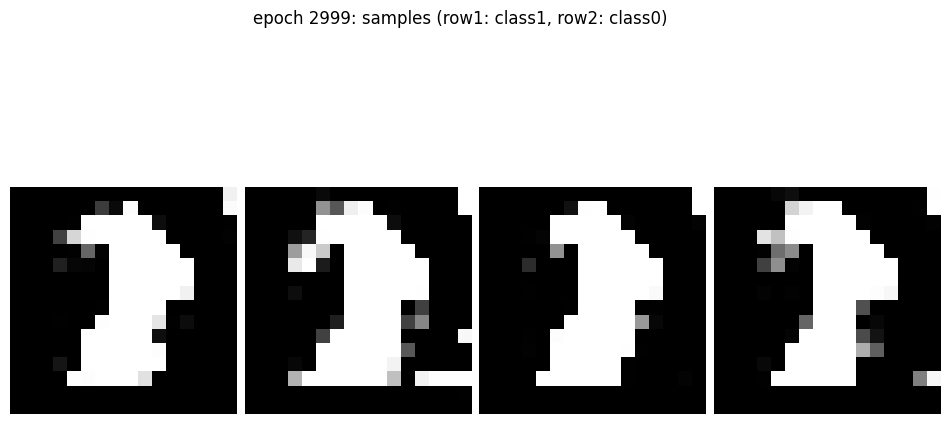

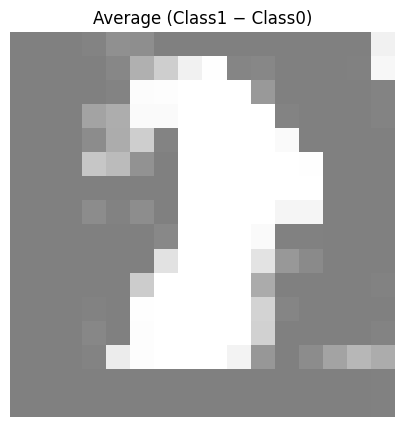

In [62]:
model.eval()
with torch.no_grad():
    samples1 = model.p_sample_loop((128, 1, INPUT_SIZE, INPUT_SIZE), temperature=1.2).cpu().numpy()
    imgs1 = samples1[:, 0, :, :]

    # average difference map (class1 - class0)
    avg1 = samples1[:, 1, :, :]
    # avg1 = loss_dict['substrate_mask'][0, :, :]
    # avg0 = imgs0.mean(axis=0)
    diff_map = avg1.mean(axis=0) # - avg0

# plot: top row = 4 samples class1, bottom row = 4 samples class0
fig = plt.figure(figsize=(12, 6))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.08)
for i in range(4):
    grid[i].imshow(avg1[i], cmap='gray')
    grid[i].axis('off')
plt.suptitle(f'epoch {epoch}: samples (row1: class1, row2: class0)')
plt.show()

# difference map
plt.figure(figsize=(5, 5))
plt.imshow(diff_map, cmap='gray', vmin=-1, vmax=1)
plt.title('Average (Class1 − Class0)')
plt.axis('off')
plt.show()
# model.train()

In [ ]:
vae_mask 

In [42]:
# model = torch.load("vae.pth")
# model.eval()
# vae_mask = np.load('vae_mask.npy')

# best_threshold = 0
# best_loss = 1e30

# threshold_range = np.linspace(0.85, 0.99, num=30)
# for thresh in threshold_range:
#     with torch.no_grad():
#         counter = 0
#         loss = 0
#         for (x, y) in cal_loader:
#             x = x.type(Tensor).to(device)
#             y = y.type(Tensor).to(device)
#             ret_dict = model(x, y,
#                              calibrate=True,
#                              t=float(thresh))

#             loss += ret_dict['loss']
#             counter += 1
#         loss = loss / counter
#         print(f'{thresh}, {loss}')
#         if loss < best_loss:
#             best_loss = loss
#             best_threshold = thresh
    
# # FIND THE BEST THRESHOLD
# t = np.quantile(vae_mask, best_threshold)

/tmp/ipykernel_36763/125185421.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("vae.pth")


AttributeError: Can't get attribute 'ModelWrapper' on <module '__main__'>

In [14]:
# RUN SVR-LSM APPROXIMATION FOR DEBUGGING PURPOSES
from sklearn import svm

# We're doing binary classification
continuous = False

svm_data = np.reshape(train_data, [train_data.shape[0], train_data.shape[2]**2])

svr_labels = train_labels
if continuous:
    svr_labels = (train_labels - train_labels.mean())
    svr_labels = svr_labels / svr_labels.std()
svm_data = svm_data / (np.linalg.norm(svm_data, axis=-1, keepdims=True) + 1e-5)

if continuous:
    svm = svm.SVR(kernel='rbf', C=0.8)
else:
    svm = svm.SVC(kernel='rbf')
svm.fit(svm_data, svr_labels)

alphas = svm.dual_coef_

backprojection = alphas * np.transpose(svm.support_vectors_)
backprojection = np.sum(backprojection, axis=1)
svm_preds = np.reshape(backprojection, [train_data.shape[2], train_data.shape[2]])
svm_preds.shape

(32, 32)

In [15]:
# RUN VLSM APPROXIMATION FOR DEBUGGING PURPOSES

idxs_p = np.where(train_labels > 0)
idxs_n = np.where(train_labels == 0)
img_size = 32

fisher_preds = np.zeros((img_size, img_size))
for i in range(img_size):
    for j in range(img_size):
        index_vox = train_data[:, 0, i, j]

        table = np.zeros((2, 2))
        table[0, 0] = np.sum(index_vox[idxs_n] == 0)
        table[0, 1] = np.sum(index_vox[idxs_n] > 0)
        table[1, 0] = np.sum(index_vox[idxs_p] == 0)
        table[1, 1] = np.sum(index_vox[idxs_p] > 0)

        p_value = scipy.stats.fisher_exact(table, 'greater')[-1]
        fisher_preds[i, j] = p_value

fisher_preds = - np.log(fisher_preds)
univar_preds = fisher_preds

In [16]:
def dice(im1, im2):
    im1 = np.asarray(im1).astype(np.bool_)
    im2 = np.asarray(im2).astype(np.bool_)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())

In [17]:
best_threshold

0.8644827586206897

In [18]:

'''
THIS IS JUST FOR DEBUGGING PURPOSES
FOR PROPER EVALUATION YOU'LL HAVE TO GET P-VALUES FOR VLSM AND SVR-LSM 
AND THEN USE FWER/FDR
'''

results = {'VDVAE-LDM': vae_mask, 'VLSM': univar_preds, 'SVR-LSM': svm_preds}

keys = ['VDVAE-LDM', 'VLSM', 'SVR-LSM']
thresholds = {}
for k in keys:
    thresholds[k] = {'dice': [0, 0], 'hausdorff': [1e10, 0], 'asd': [1e10, 0],
                    }

for k in results:
    results[k] = results[k] - results[k].min()
    results[k] = results[k] / (results[k].max())

# threshold_range = np.linspace(0.8, 0.98, num=20)
threshold_range = [0.9]

for thresh in threshold_range:
    for k in thresholds:
        if k == 'VDVAE-LDM':
            t = np.quantile(results[k], best_threshold)
        else:
            t = np.quantile(results[k], thresh)
        bin_res = results[k] > t

        preds = np.expand_dims(np.expand_dims(results[k], axis=0), axis=0)
        bin_preds = np.expand_dims(np.expand_dims(bin_res, axis=0), axis=0)
        monai_gt = np.expand_dims(np.expand_dims(substrate, axis=0), axis=0)
        
        dice_s = dice(bin_res, substrate)
            
        if dice_s > thresholds[k]['dice'][0]:
            thresholds[k]['dice'][0] = round(dice_s, 2)
            if k == 'VDVAE-LDM':
                thresholds[k]['dice'][1] = best_threshold
            else:
                thresholds[k]['dice'][1] = thresh
            
            # haus = compute_hausdorff_distance(bin_preds, monai_gt).numpy()[0][0]
            # asd = compute_average_surface_distance(bin_preds, monai_gt,
            #                                        symmetric=False).numpy()[0][0]
            
#             thresholds[k]['hausdorff'][0] = round(haus, 2)
#             thresholds[k]['hausdorff'][1] = thresh
            
#             thresholds[k]['asd'][0] = round(asd, 2)
#             thresholds[k]['asd'][1] = thresh
            
            
thresholds

{'VDVAE-LDM': {'dice': [0.58, 0.8644827586206897],
  'hausdorff': [10000000000.0, 0],
  'asd': [10000000000.0, 0]},
 'VLSM': {'dice': [0.6, 0.9],
  'hausdorff': [10000000000.0, 0],
  'asd': [10000000000.0, 0]},
 'SVR-LSM': {'dice': [0.69, 0.9],
  'hausdorff': [10000000000.0, 0],
  'asd': [10000000000.0, 0]}}

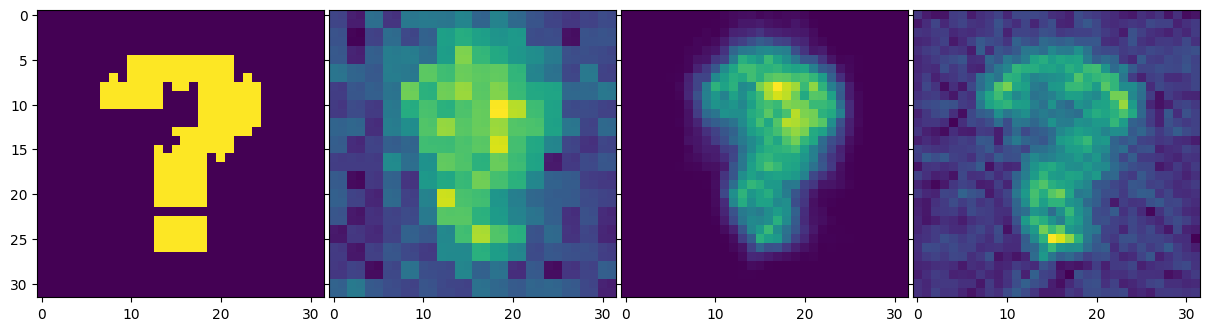

In [19]:
fig = plt.figure(figsize=(15., 15.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(1, 4),
                 axes_pad=0.05,
                 share_all=True
                 )

grid[0].imshow(substrate)
grid[1].imshow(vae_mask)
grid[2].imshow(univar_preds)
grid[3].imshow(svm_preds)